# Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from econml.grf import CausalIVForest
from statsmodels.regression.linear_model import OLS
from statsmodels.base.covtype import get_robustcov_results
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Read Data

In [2]:
df = pd.read_feather("../Data_Used/ohie_full_intermediate_dataset.feather")
print(df.shape)
display(df.head())

(16579, 96)


,person_id,household_id,Z_lottery,numhh_list,X_zip_msa_list,X_surv_lang_0m,X_needmet_med_0m,X_needmet_rx_0m,X_rx_num_mod_0m,X_doc_num_mod_0m,X_er_num_mod_0m,X_hosp_num_mod_0m,X_need_rx_0m,X_need_med_0m,X_ins_months_0m,X_health_gen_0m,X_baddays_phys_0m,X_baddays_ment_0m,X_health_chg_0m,X_dia_dx_0m,X_ast_dx_0m,X_hbp_dx_0m,X_emp_dx_0m,X_chf_dx_0m,X_dep_dx_0m,X_female_0m,X_edu_0m,X_race_hisp_0m,X_race_white_0m,X_race_black_0m,X_race_amerindian_0m,X_race_asian_0m,X_race_pacific_0m,X_race_other_qn_0m,X_employ_0m,X_employ_hrs_0m,X_hhinc_cat_0m,X_hhsize_0m,X_num19_0m,X_cost_any_oop_0m,X_cost_borrow_0m,X_cost_any_owe_0m,X_cost_tot_owe_0m,X_cost_refused_0m,X_cost_tot_oop_correct_0m,weight_12m,weight_intensive_12m,weight_newlottery_12m,Y_cost_any_owe_12m,Y_cost_tot_owe_12m,Y_cost_borrow_12m,Y_cost_refused_12m,Y_cost_tot_oop_12m,Y_cost_any_oop_12m,Y_hhinc_cat_12m,Y_cost_doc_oop_12m,Y_cost_er_oop_12m,Y_cost_rx_oop_12m,Y_cost_oth_oop_12m,W_medicaid,ohp_all_mo_firstn_30sep2009,X_need_med_0m_missing,X_needmet_med_0m_missing,X_need_rx_0m_missing,X_needmet_rx_0m_missing,X_employ_0m_missing,X_race_hisp_0m_missing,X_race_white_0m_missing,X_race_black_0m_missing,X_race_amerindian_0m_missing,X_race_asian_0m_missing,X_race_pacific_0m_missing,X_race_other_qn_0m_missing,X_cost_borrow_0m_missing,X_cost_any_owe_0m_missing,X_cost_refused_0m_missing,X_cost_any_oop_0m_missing,X_rx_num_mod_0m_missing,X_doc_num_mod_0m_missing,X_er_num_mod_0m_missing,X_hosp_num_mod_0m_missing,X_hhsize_0m_missing,X_num19_0m_missing,X_health_gen_0m_missing,X_health_chg_0m_missing,X_hhinc_cat_0m_missing,X_edu_0m_missing,X_employ_hrs_0m_missing,X_baddays_phys_0m_missing,X_baddays_ment_0m_missing,X_ins_months_0m_missing,X_cost_tot_owe_0m_missing,X_cost_tot_oop_correct_0m_missing,Y_income_num_12m,Y_catastrophic_exp_12m,X_age_0m
5,6,100006,1,1,1.0,1,1,1,0,0,0,0,0,0,2.0,3.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0,1,0,0,0,0,0,1,4.0,2.0,1,0,0,0,1,700.0,0,188.169267,1.0,1.0,1.0,1.0,1500.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6250.0,0.0,62.0
7,8,102094,0,2,1.0,1,1,1,2,3,0,0,1,1,0.0,4.0,0.0,14.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0,1,0,0,0,0,0,0,1.0,1.0,2,0,1,1,1,30.0,0,180.000000,1.0,1.0,1.0,1.0,NaN,1.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,40.0
8,9,100009,0,1,1.0,1,0,1,1,1,0,0,1,1,3.0,2.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0,1,0,0,0,0,0,0,1.0,8.0,2,1,1,0,0,0.0,0,240.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,75.0,1.0,5.0,25.0,0.0,50.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8750.0,0.0,31.0
9,10,111771,0,2,0.0,1,0,0,3,3,0,0,1,1,2.0,3.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1,1,0,0,0,0,0,1,4.0,5.0,6,4,1,1,1,423.0,0,3120.000000,1.0,1.0,1.0,1.0,1000.0,1.0,0.0,1300.0,1.0,5.0,1300.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8750.0,0.0,36.0
12,13,100013,1,1,0.0,1,0,1,0,2,0,0,0,1,2.0,2.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,1,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,0.0,0,400.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1250.0,0.0,45.0


In [3]:
# Core identification + design columns
id_cols = ["person_id",
           "household_id",
           "Z_lottery",
           "W_medicaid",
           "weight_12m",
           "weight_intensive_12m",
           "weight_newlottery_12m"]

# All columns starting with Y_
all_Y_cols = [c for c in df.columns if c.startswith("Y_")]
print("All Y_ columns:", all_Y_cols)
print('-'*100)

# Main outcomes I care about
main_outcomes = ["Y_cost_any_owe_12m",     
                 "Y_cost_tot_owe_12m",    
                 "Y_cost_tot_oop_12m",     
                 "Y_catastrophic_exp_12m",  
                 "Y_cost_borrow_12m",
                 "Y_cost_refused_12m"]

# All X_ columns
all_X_like = [c for c in df.columns if c.startswith("X_")]

# Missingness flags: columns ending with "_missing"
missing_flag_cols = [c for c in all_X_like if c.endswith("_missing")]

# Base X covariates: X_ columns that are NOT flags
X_base_cols = [c for c in all_X_like if not c.endswith("_missing")]

# Final feature list: base Xs + flags
final_features = X_base_cols + missing_flag_cols

print(f"Number of base X covariates: {len(X_base_cols)}")
print(f"Number of missing flags:     {len(missing_flag_cols)}")
print(f"Total features in X:         {len(final_features)}")

# Check there are no NAs in X features (should be zero after imputation)
print("Total missing in X features:", df[final_features].isna().sum().sum())

All Y_ columns: ['Y_cost_any_owe_12m', 'Y_cost_tot_owe_12m', 'Y_cost_borrow_12m', 'Y_cost_refused_12m', 'Y_cost_tot_oop_12m', 'Y_cost_any_oop_12m', 'Y_hhinc_cat_12m', 'Y_cost_doc_oop_12m', 'Y_cost_er_oop_12m', 'Y_cost_rx_oop_12m', 'Y_cost_oth_oop_12m', 'Y_income_num_12m', 'Y_catastrophic_exp_12m']
----------------------------------------------------------------------------------------------------
Number of base X covariates: 42
Number of missing flags:     32
Total features in X:         74
Total missing in X features: 0


# Fix Critical Data Quality Issue

In [4]:
print("\n" + "="*80)
print("WINSORIZING CONTINUOUS 12M OUTCOMES")
print("="*80)

def winsorize_outlier(series, lower=None, upper=0.99, name=""):
    """
    Winsorize outliers at specified quantiles.
    If lower is None, only upper-tail winsorization is applied.
    Returns: winsorized series, (lower_bound, upper_bound).
    """
    if lower is not None:
        lower_bound = series.quantile(lower)
    else:
        lower_bound = series.min()
        
    upper_bound = series.quantile(upper)
    
    n_top = (series > upper_bound).sum()
    n_bottom = (series < lower_bound).sum()
    extreme_vals = series[series > upper_bound].sort_values(ascending=False).head(3)
    
    print(f"\n{name}:")
    print(f"  • Winsorizing to [{lower_bound:,.0f}, {upper_bound:,.0f}]")
    if lower is not None:
        print(f"  • Bottom {100*lower:.2f}% values capped: {n_bottom} obs")
    print(f"  • Top {100*(1-upper):.2f}% values capped: {n_top} obs")
    print(f"  • Extreme values (top 3 pre-cap): {extreme_vals.tolist()}")
    
    winsorized = series.clip(lower=lower_bound, upper=upper_bound)
    return winsorized, (lower_bound, upper_bound)

continuous_outcomes = ['Y_cost_tot_owe_12m', 'Y_cost_tot_oop_12m']
winsorization_bounds = {}

for col in continuous_outcomes:
    df[col], bounds = winsorize_outlier(
        df[col],
        lower=None,          # no lower-tail clipping
        upper=0.99,         # cap top 0.1%
        name=f"{col} (12m outcome)"
    )
    winsorization_bounds[col] = bounds


WINSORIZING CONTINUOUS 12M OUTCOMES

Y_cost_tot_owe_12m (12m outcome):
  • Winsorizing to [0, 40,000]
  • Top 1.00% values capped: 143 obs
  • Extreme values (top 3 pre-cap): [1100074713088.0, 3490110.0, 3200000.0]

Y_cost_tot_oop_12m (12m outcome):
  • Winsorizing to [0, 4,600]
  • Top 1.00% values capped: 158 obs
  • Extreme values (top 3 pre-cap): [22003050.0, 8301400.0, 200040.0]


# Outcome-Specific Subsets

In [5]:
def make_analysis_sample(df, y_col):
    """Return df restricted to non-missing outcome y_col, with a printout."""
    keep = df[y_col].notna()
    df_y = df.loc[keep].copy()
    print(f"{y_col}: {df_y.shape[0]:,} observations (out of {df.shape[0]:,})")
    return df_y

analysis_samples = {}
for y in main_outcomes:
    analysis_samples[y] = make_analysis_sample(df, y)

Y_cost_any_owe_12m: 16,377 observations (out of 16,579)
Y_cost_tot_owe_12m: 14,354 observations (out of 16,579)
Y_cost_tot_oop_12m: 15,869 observations (out of 16,579)
Y_catastrophic_exp_12m: 15,155 observations (out of 16,579)
Y_cost_borrow_12m: 16,384 observations (out of 16,579)
Y_cost_refused_12m: 15,783 observations (out of 16,579)


# ITTs By Outcome

In [6]:
def weighted_mean_by_Z(df_sample, var, w):
    """
    Return weighted mean of `var` by Z_lottery, using weights `w`.
    """
    num = (df_sample[var] * df_sample[w]).groupby(df_sample["Z_lottery"]).sum()
    den = df_sample[w].groupby(df_sample["Z_lottery"]).sum()
    return (num / den).astype(float)


def run_itt_for_outcome(df_sample, y_col, use_weight=False):
    """
    Compute ITT (Z -> Y) for a given outcome.
    - df_sample: analysis sample with non-missing Y
    - y_col: outcome column
    - use_weight: True uses weight_12m (WLS), False unweighted OLS
    """
    weight_var   = "weight_12m" if use_weight else None
    weight_label = "weighted" if use_weight else "unweighted"

    # Drop zero / missing weights in the weighted spec
    if use_weight:
        df_work = df_sample.loc[df_sample[weight_var].notna() & (df_sample[weight_var] > 0)].copy()
    else:
        df_work = df_sample.copy()

    print("\n" + "-"*70)
    print(f"ITT for {y_col} ({weight_label})")
    print("-"*70)

    formula = f"{y_col} ~ Z_lottery"

    if use_weight:
        means = weighted_mean_by_Z(df_work, y_col, weight_var)
        diff = float(means[1] - means[0])
        mean_Z0, mean_Z1 = means[0], means[1]
        print("\nWeighted means by lottery status (Z):")
        print(means.to_frame(name="weighted_mean"))
        print(f"\nRaw *weighted* difference (Z=1 - Z=0): {diff:.4f}")
        model = smf.wls(formula, data=df_work, weights=df_work[weight_var]).fit(
            cov_type="cluster",
            cov_kwds={"groups": df_work["household_id"]})

    else:
        means = df_work.groupby("Z_lottery")[y_col].agg(["mean"])
        diff = float(means.iloc[1, 0] - means.iloc[0, 0])
        mean_Z0, mean_Z1 = means.iloc[0, 0], means.iloc[1, 0]
        print(f"\nRaw difference (Z=1 - Z=0): {diff:.4f}")
        model = smf.ols(formula, data=df_work).fit(
            cov_type="cluster",
            cov_kwds={"groups": df_work["household_id"]})
    
    print("\nRegression results (cluster-robust):")
    print(model.summary().tables[1].as_text())

    return {
        "outcome": y_col,
        "weighting": weight_label,
        "coef": model.params["Z_lottery"],
        "se": model.bse["Z_lottery"],
        "pvalue": model.pvalues["Z_lottery"],
        "mean_Z0": mean_Z0,
        "mean_Z1":mean_Z1,
        "n": len(df_work),
    }
   

In [7]:
# running ITT for each outcome
itt_results = []

for y in main_outcomes:
    df_y = analysis_samples[y]
    
    # Unweighted ITT
    itt_unweighted = run_itt_for_outcome(df_y, y, use_weight=False)
    itt_results.append(itt_unweighted)

    # weighted ITT
    print(f"For {y}: dropping { (df_y['weight_12m'] == 0).sum() } zero-weight obs in weighted spec.")
    itt_weighted = run_itt_for_outcome(df_y, y, use_weight=True)
    itt_results.append(itt_weighted)


----------------------------------------------------------------------
ITT for Y_cost_any_owe_12m (unweighted)
----------------------------------------------------------------------

Raw difference (Z=1 - Z=0): -0.0595

Regression results (cluster-robust):
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5764      0.006    102.316      0.000       0.565       0.587
Z_lottery     -0.0595      0.008     -7.335      0.000      -0.075      -0.044
For Y_cost_any_owe_12m: dropping 13 zero-weight obs in weighted spec.

----------------------------------------------------------------------
ITT for Y_cost_any_owe_12m (weighted)
----------------------------------------------------------------------

Weighted means by lottery status (Z):
           weighted_mean
Z_lottery               
0               0.581089
1               0.525284

Raw *weighted* difference (Z=1 - Z=

In [8]:
# Compiling results
print("SUMMARY TABLE: ITT EFFECTS (CLUSTER-ROBUST)")
results_df = pd.DataFrame(itt_results)
outcome_labels = {
    'Y_cost_any_owe_12m': 'Any Medical Debt',
    'Y_cost_tot_owe_12m': 'Total Medical Debt ($)',
    'Y_cost_tot_oop_12m': 'Total OOP Spending ($)',
    'Y_catastrophic_exp_12m': 'Catastrophic Expenditure',
    'Y_cost_borrow_12m': 'Borrowed/Skipped Bills',
    'Y_cost_refused_12m': 'Care Refused'}

results_df['outcome_label'] = results_df['outcome'].map(outcome_labels)

def add_stars(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.10:
        return '*'
    return ''

results_df['stars'] = results_df['pvalue'].apply(add_stars)

# Format for display
results_df['estimate'] = results_df.apply(
    lambda r: f"{r['coef']:.3f}{r['stars']} ({r['se']:.3f})", axis=1)

# Pivot to wide format (unweighted vs weighted)
summary_table = results_df.pivot(index='outcome_label', columns='weighting', 
                                 values='estimate')[['unweighted', 'weighted']]

print("\nITT Estimates: Coefficient (Standard Error)")
print("(*** p<0.01, ** p<0.05, * p<0.10)")
print("\n" + summary_table.to_string())
print("\n" + "="*70)

# Save results
results_df.to_csv("../Output/itt_results.csv", index=False)
summary_table.to_csv("../Output/itt_summary_table.csv")

SUMMARY TABLE: ITT EFFECTS (CLUSTER-ROBUST)

ITT Estimates: Coefficient (Standard Error)
(*** p<0.01, ** p<0.05, * p<0.10)

weighting                           unweighted               weighted
outcome_label                                                        
Any Medical Debt             -0.059*** (0.008)      -0.056*** (0.009)
Borrowed/Skipped Bills       -0.063*** (0.008)      -0.059*** (0.008)
Care Refused                 -0.014*** (0.004)      -0.012*** (0.004)
Catastrophic Expenditure     -0.026*** (0.004)      -0.024*** (0.004)
Total Medical Debt ($)    -449.348*** (97.373)  -398.627*** (118.197)
Total OOP Spending ($)     -48.238*** (10.880)    -47.686*** (12.795)



# First Stage By Outcome

In [9]:
def run_first_stage(df_sample, use_weight=False):
    """
    First stage: W_medicaid ~ Z_lottery
    Cluster-robust SEs at household level.
    
    Parameters
    ----------
    df_full : pd.DataFrame
        Aanalysis sample.
    use_weight : bool
        If True, use weight_12m. If False, unweighted
    """
    
    if use_weight:
        # Drop zero-weight obs; they don't contribute to weighted estimators
        df_fs = df_sample.loc[df_sample["weight_12m"] > 0].copy()
        assert df_fs["weight_12m"].min() > 0, "Weights must be strictly positive in weighted spec."
        weight_var = "weight_12m"
        label = "weighted"
    else:
        df_fs = df_sample.copy()
        weight_var = None
        label = "unweighted"

    # Basic sanity checks
    assert set(df_fs["Z_lottery"].dropna().unique()) <= {0, 1},  "Z_lottery must be binary {0,1}."
    assert set(df_fs["W_medicaid"].dropna().unique()) <= {0, 1}, "W_medicaid must be binary {0,1}."
    
    print(f"\n--- First stage ({label}) ---")
    print(f"Sample size: {len(df_fs):,} observations")

    # =========================
    # Descriptive means by Z
    # =========================
    if use_weight:
        # Weighted means + counts
        mean_by_Z = weighted_mean_by_Z(df_fs, "W_medicaid", weight_var)
        count_by_Z = df_fs.groupby("Z_lottery")["W_medicaid"].size()
        tab = pd.DataFrame({
            "weighted_mean": mean_by_Z,
            "count": count_by_Z})
        print("\nMedicaid coverage by lottery status (Z) [weighted descriptives]:")
        print(tab)
        complier_rate = float(mean_by_Z.loc[1] - mean_by_Z.loc[0])
    else:
        # Purely unweighted means/std/count
        tab = df_fs.groupby("Z_lottery")["W_medicaid"].agg(["mean", "std", "count"])
        print("\nMedicaid coverage by lottery status (Z) [unweighted descriptives]:")
        print(tab)
        complier_rate = float(tab.loc[1, "mean"] - tab.loc[0, "mean"])

    print(f"\nEstimated complier rate (E[W|Z=1] - E[W|Z=0]): {complier_rate:.4f}")

    # =========================
    # Regression: W_medicaid ~ Z_lottery
    # =========================
    formula = "W_medicaid ~ Z_lottery"
    
    if not use_weight:
        model = smf.ols(formula, data=df_fs).fit(
            cov_type="cluster",
            cov_kwds={"groups": df_fs["household_id"]})
    else:
        model = smf.wls(formula, data=df_fs, weights=df_fs[weight_var]).fit(
            cov_type="cluster",
            cov_kwds={"groups": df_fs["household_id"]})

    print("\nRegression results (cluster-robust):")
    print(model.summary().tables[1].as_text())

    beta = model.params["Z_lottery"]
    se   = model.bse["Z_lottery"]
    t_stat = beta / se
    F_robust = t_stat**2   # robust F based on robust t-stat

    print(f"\nCluster-robust t-stat on Z_lottery: {t_stat:.2f}")
    print(f"Approximate first-stage F (t^2):    {F_robust:.2f}")

    return {
        "weighting": label,
        "beta_fs": beta,
        "se_fs": se,
        "t_fs": t_stat,
        "F_fs": F_robust,
        "complier_rate": complier_rate,
        "n": len(df_fs),
    }


# # Run both specs and collect in a small summary table
# fs_full_unweighted = run_first_stage(df, use_weight=False)
# fs_full_weighted   = run_first_stage(df, use_weight=True)

# fs_results = pd.DataFrame([fs_full_unweighted, fs_full_weighted])
# display(fs_results)

In [10]:
# First-stage by outcome and weighting (aligned with ITT samples)
fs_by_outcome = {}

for y in main_outcomes:
    df_y = analysis_samples[y]

    # Unweighted first stage on the same sample used for ITT
    print(f"\n=== First stage for {y} (unweighted) ===")
    fs_unw = run_first_stage(df_y, use_weight=False)
    fs_by_outcome[(y, "unweighted")] = fs_unw

    # Weighted first stage: drop zero-weight observations
    print(f"\n=== First stage for {y} (weighted) ===")
    fs_w = run_first_stage(df_y, use_weight=True)
    fs_by_outcome[(y, "weighted")] = fs_w


=== First stage for Y_cost_any_owe_12m (unweighted) ===

--- First stage (unweighted) ---
Sample size: 16,377 observations

Medicaid coverage by lottery status (Z) [unweighted descriptives]:
               mean       std  count
Z_lottery                           
0          0.130717  0.337110   8331
1          0.449540  0.497478   8046

Estimated complier rate (E[W|Z=1] - E[W|Z=0]): 0.3188

Regression results (cluster-robust):
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1307      0.004     34.178      0.000       0.123       0.138
Z_lottery      0.3188      0.007     44.866      0.000       0.305       0.333

Cluster-robust t-stat on Z_lottery: 44.87
Approximate first-stage F (t^2):    2012.94

=== First stage for Y_cost_any_owe_12m (weighted) ===

--- First stage (weighted) ---
Sample size: 16,364 observations

Medicaid coverage by lottery status (Z) [we

In [11]:
fs_results = (pd.DataFrame([
                {"outcome": key[0],
                 "weighting": key[1],
                 **val}
                 for key, val in fs_by_outcome.items()]))

fs_results["outcome_label"] = fs_results["outcome"].map(outcome_labels)
fs_cols = ["outcome_label", "weighting", "beta_fs", "se_fs", "t_fs", "F_fs", "complier_rate", "n"]

display(fs_results[fs_cols])

,outcome_label,weighting,beta_fs,se_fs,t_fs,F_fs,complier_rate,n
0,Any Medical Debt,unweighted,0.318824,0.007106,44.865842,2012.943761,0.318824,16377
1,Any Medical Debt,weighted,0.320233,0.007651,41.857646,1752.062551,0.320233,16364
2,Total Medical Debt ($),unweighted,0.314748,0.007541,41.737193,1741.993264,0.314748,14354
3,Total Medical Debt ($),weighted,0.316120,0.008162,38.728988,1499.934546,0.316120,14341
4,Total OOP Spending ($),unweighted,0.319011,0.007205,44.276905,1960.444274,0.319011,15869
5,Total OOP Spending ($),weighted,0.320960,0.007766,41.330973,1708.249306,0.320960,15856
6,Catastrophic Expenditure,unweighted,0.320704,0.007366,43.540241,1895.752599,0.320704,15155
7,Catastrophic Expenditure,weighted,0.321231,0.007922,40.547011,1644.060111,0.321231,15142
8,Borrowed/Skipped Bills,unweighted,0.317430,0.007113,44.624968,1991.387751,0.317430,16384
9,Borrowed/Skipped Bills,weighted,0.319084,0.007657,41.671481,1736.512330,0.319084,16371


# LATEs By Outcome

In [12]:
# ITT results already collected earlier
itt_df = pd.DataFrame(itt_results)

# Turn fs_by_outcome dict into a DataFrame
fs_results = pd.DataFrame([
    {"outcome": key[0],
    "weighting": key[1],
    **val} for key, val in fs_by_outcome.items()])

# Sanity check: each outcome × weighting appears once in both
assert set(zip(itt_df["outcome"], itt_df["weighting"])) == \
       set(zip(fs_results["outcome"], fs_results["weighting"])), \
       "Mismatch between ITT and first-stage specs!"

# Merge ITT and first stage into one IV frame
iv_df = itt_df.merge(
    fs_results[["outcome", "weighting",
                "beta_fs", "se_fs", "F_fs", "complier_rate", "n"]],
    on=["outcome", "weighting"],
    how="left",
    validate="1:1")

In [13]:
# Compute LATE and SE via delta method (ignoring Cov(beta_YZ, beta_WZ))
def compute_late_row(row):
    """
    Given an IV row with:
      - coef, se        = ITT (Z -> Y)
      - beta_fs, se_fs  = first stage (Z -> W)
    construct Wald LATE = coef / beta_fs and its SE via delta method:
    
      Var(a/b) ≈ (1/b^2) Var(a) + (a^2 / b^4) Var(b)
    
    Here we *ignore* Cov(a, b), which is reasonable given the
    extremely strong first stage and large sample size.
    """
    beta_yz = row["coef"]
    se_yz   = row["se"]
    beta_wz = row["beta_fs"]
    se_wz   = row["se_fs"]
    
    late = beta_yz / beta_wz
    
    var_yz = se_yz**2
    var_wz = se_wz**2
    var_ratio = (var_yz / (beta_wz**2)) + ((beta_yz**2) * var_wz / (beta_wz**4))
    se_late = np.sqrt(var_ratio)
    
    return pd.Series({"late": late, "late_se": se_late})

iv_df[["late", "late_se"]] = iv_df.apply(compute_late_row, axis=1)

# LATE p-values and stars
def late_pvalue(row):
    z = row["late"] / row["late_se"]
    return 2 * (1 - stats.norm.cdf(np.abs(z)))

iv_df["late_pvalue"] = iv_df.apply(late_pvalue, axis=1)
iv_df["late_stars"]  = iv_df["late_pvalue"].apply(add_stars)  # add_stars defined earlier
iv_df["outcome_label"] = iv_df["outcome"].map(outcome_labels)

# Formatted LATE estimates
iv_df["late_estimate"] = iv_df.apply(
    lambda r: f"{r['late']:.3f}{r['late_stars']} ({r['late_se']:.3f})", axis=1)

# Summary table: LATE by outcome × weighting
late_summary = iv_df.pivot(
    index="outcome_label",
    columns="weighting",
    values="late_estimate"
)[["unweighted", "weighted"]]

print("\nLATE Estimates: Effect of Medicaid Coverage (W) on Outcomes")
print("(Coefficient (SE), stars from Wald test; *** p<0.01, ** p<0.05, * p<0.10)\n")
print(late_summary.to_string())

# Save full IV results + formatted tables
iv_df.to_csv("../Output/iv_results_full.csv", index=False)
late_summary.to_csv("../Output/late_summary_table.csv")


LATE Estimates: Effect of Medicaid Coverage (W) on Outcomes
(Coefficient (SE), stars from Wald test; *** p<0.01, ** p<0.05, * p<0.10)

weighting                             unweighted                weighted
outcome_label                                                           
Any Medical Debt               -0.187*** (0.026)       -0.174*** (0.028)
Borrowed/Skipped Bills         -0.198*** (0.025)       -0.186*** (0.027)
Care Refused                   -0.045*** (0.013)       -0.039*** (0.014)
Catastrophic Expenditure       -0.080*** (0.013)       -0.076*** (0.014)
Total Medical Debt ($)    -1427.643*** (311.252)  -1260.997*** (375.314)
Total OOP Spending ($)      -151.210*** (34.276)    -148.573*** (40.026)


# Stratified LATEs by Risk × Liquidity (Pre-Forest Diagnostics)

## Constructing p_i

In [14]:
# Construct p_i (risk index)
risk_vars = [# Utilization / need at baseline
    "X_need_med_0m", "X_need_rx_0m",
    "X_needmet_med_0m", "X_needmet_rx_0m",  # have to reverse order, 0 is not met, 1 is met → higher is better
    "X_rx_num_mod_0m", "X_doc_num_mod_0m",
    "X_er_num_mod_0m", "X_hosp_num_mod_0m",

    # Health status
    "X_health_gen_0m",   # have to reverse order, 1=poor, 5=excellent → higher is better
    "X_health_chg_0m",   
    "X_baddays_phys_0m",
    "X_baddays_ment_0m",

    # Diagnoses
    "X_dia_dx_0m", "X_ast_dx_0m", "X_hbp_dx_0m",
    "X_emp_dx_0m", "X_chf_dx_0m", "X_dep_dx_0m"]

risk_vars = [v for v in risk_vars if v in df.columns]  

# Standardize and align directions
# Risk block: larger = worse health risk
risk_data = df[risk_vars].copy()

# Flip general health so higher = worse health 
# X_health_gen_0m: 1=poor, 5=excellent 
risk_data["X_health_gen_0m"] = 6 - risk_data["X_health_gen_0m"]

# Flip needmet variables so higher = worse
risk_data["X_needmet_med_0m"] = 1 - risk_data["X_needmet_med_0m"]
risk_data["X_needmet_rx_0m"] = 1 - risk_data["X_needmet_rx_0m"]

# Standardize each risk variable
risk_scaler = StandardScaler()
risk_std = risk_scaler.fit_transform(risk_data.values)
risk_std_df = pd.DataFrame(risk_std, columns=risk_vars, index=df.index)

# Risk index: simple average across standardized risk vars
df["risk_index_0m"] = risk_std_df.mean(axis=1)

## Constructing L_i

In [15]:
# Construct L_i (liquidity index)

# Define liquidity variables (baseline)

# First create equivalized income from income category + hhsize
# (already used an income_map for 12m Y; here using a similar mapping for X_hhinc_cat_0m)
income_map_0m = {
    1: 0,
    2: 1250,
    3: 3750,
    4: 6250,
    5: 8750,
    6: 11250,
    7: 13750,
    8: 16250,
    9: 18750,
    10: 21250,
    11: 23750,
    12: 26250,
    13: 28750,
    14: 31250,
    15: 33750,
    16: 36250,
    17: 38750,
    18: 41250,
    19: 43750,
    20: 46250,
    21: 48750,
    22: 60000 }  # "$50,001 or more" does not matter

df["X_income_num_0m"] = df["X_hhinc_cat_0m"].map(income_map_0m)

# Handle hhsize <= 0 
hhsize = df["X_hhsize_0m"].copy()
# Flag weird values
bad = (~np.isfinite(hhsize)) | (hhsize <= 0)
print(f"Household size <= 0 or non-finite: {bad.sum()} rows")

# For now: set them to 1 (single-person household) so sqrt is well-defined
hhsize[bad] = 1.0
df["X_eq_income_0m"] = df["X_income_num_0m"] / np.sqrt(hhsize)

liquidity_vars = [# "Resources" (higher => less constrianed)
                    "X_eq_income_0m",
                    "X_edu_0m",
                    "X_employ_0m", "X_employ_hrs_0m",
                
                    # Baseline financial strain from medical costs (higher => more constrained)
                    "X_cost_any_oop_0m",
                    "X_cost_tot_oop_correct_0m",
                    "X_cost_any_owe_0m",
                    "X_cost_tot_owe_0m",
                    "X_cost_borrow_0m",
                    "X_cost_refused_0m"]

liquidity_vars = [v for v in liquidity_vars if v in df.columns]

# Liquidity: want *higher value = less liquidity constraint*
liq_data = df[liquidity_vars].copy()

# For resource variables, higher value = less slack, so we flip the sign
strain_vars = ["X_cost_any_oop_0m",
                    "X_cost_tot_oop_correct_0m",
                    "X_cost_any_owe_0m",
                    "X_cost_tot_owe_0m",
                    "X_cost_borrow_0m",
                    "X_cost_refused_0m"]

for col in strain_vars:
    liq_data[col] = -liq_data[col]

# Now all liquidity vars are oriented so higher = more liquidity
liq_scaler = StandardScaler()
liq_std = liq_scaler.fit_transform(liq_data.values)
liq_std_df = pd.DataFrame(liq_std, columns=liquidity_vars, index=df.index)

df["liquidity_index_0m"] = liq_std_df.mean(axis=1)

Household size <= 0 or non-finite: 1 rows


## p_i & L_i Quickview

In [16]:
print("\nConstructed indices:") 
print(df[["risk_index_0m", "liquidity_index_0m"]].describe().round(3)) 

# High/low flags for risk and liquidity (median split)
risk_med = df["risk_index_0m"].median() 
liq_med = df["liquidity_index_0m"].median() 

df["high_risk_0m"] = (df["risk_index_0m"] > risk_med).astype(int)
df["high_liquidity_0m"] = (df["liquidity_index_0m"] > liq_med).astype(int) 

print("\nRisk/liquidity medians:") 
print(f" risk median = {risk_med:.3f}") 
print(f" liquidity median = {liq_med:.3f}")

print("\nCross-tab of high_risk_0m × high_liquidity_0m:") 
print(pd.crosstab(df["high_risk_0m"], df["high_liquidity_0m"]))



Constructed indices:
       risk_index_0m  liquidity_index_0m
count      16579.000           16579.000
mean           0.000              -0.000
std            0.474               0.435
min           -0.870              -2.438
25%           -0.367              -0.295
50%           -0.042               0.013
75%            0.311               0.302
max            2.561               1.632

Risk/liquidity medians:
 risk median = -0.042
 liquidity median = 0.013

Cross-tab of high_risk_0m × high_liquidity_0m:
high_liquidity_0m     0     1
high_risk_0m                 
0                  2621  5669
1                  5669  2620


## Get The Stratified LATEs, By Outcomes

In [17]:
def stratified_iv_for_group(df_y, y_col, group_mask, group_name, 
                            use_weight=False, min_n=200):
    """
    Run IV (ITT + first stage + LATE) within a subgroup defined by group_mask.

    Parameters
    ----------
    df_y : pd.DataFrame
        Outcome-specific analysis sample (e.g. analysis_samples[y_col]).
        Must contain: y_col, Z_lottery, W_medicaid, household_id, weight_12m.
    y_col : str
        Outcome variable name (e.g. 'Y_cost_tot_oop_12m').
    group_mask : pd.Series[bool]
        Boolean mask on df_y (same index) indicating the subgroup.
    group_name : str
        Descriptive name for the subgroup (e.g. 'High risk, high constraint').
    use_weight : bool
        If True, use weight_12m > 0; else unweighted
    min_n : int
        Minimum N threshold at which we trust the estimates (just for warnings).

    Returns
    -------
    dict or None
        Dictionary of results for this subgroup and weighting, or None if
        the group is empty or has only one Z value.
    """
    label = "weighted" if use_weight else "unweighted"

    # Restrict to group
    df_sub = df_y.loc[group_mask].copy()
    if df_sub.shape[0] == 0:
        print(f"\n{group_name} ({label}): N=0, skipping.")
        return None

    # For weighted spec, drop zero-weight obs
    if use_weight:
        df_sub = df_sub.loc[df_sub["weight_12m"] > 0].copy()
        if df_sub.shape[0] == 0:
            print(f"\n{group_name} ({label}): N=0 after dropping zero weights, skipping.")
            return None
        weights = df_sub["weight_12m"]
    else:
        weights = None

    n = df_sub.shape[0]
    print(f"\n=== {group_name} — {y_col} ({label}) ===")
    print(f"N = {n:,}")

    if n < min_n:
        print(f"N < {min_n} — estimates will be noisy.")

    # Sanity: need both Z values
    if df_sub["Z_lottery"].nunique() < 2:
        print("Only one value of Z in this group; cannot estimate IV.")
        return None

    # ---------- First stage: W_medicaid ~ Z_lottery ----------
    fs_formula = "W_medicaid ~ Z_lottery"
    if use_weight:
        fs_model = smf.wls(fs_formula, data=df_sub, weights=weights).fit(
            cov_type="cluster",
            cov_kwds={"groups": df_sub["household_id"]})
    else:
        fs_model = smf.ols(fs_formula, data=df_sub).fit(
            cov_type="cluster",
            cov_kwds={"groups": df_sub["household_id"]})

    beta_wz = fs_model.params["Z_lottery"]
    se_wz   = fs_model.bse["Z_lottery"]
    t_fs    = beta_wz / se_wz
    F_fs    = t_fs**2

    print(f"First stage: beta_WZ = {beta_wz:.3f}, SE = {se_wz:.3f}, t = {t_fs:.2f}, F ≈ {F_fs:.1f}")
    if F_fs < 10:
        print("Weak instrument (F < 10). LATE will be unstable.")

    # ---------- ITT: Y ~ Z_lottery ----------
    itt_formula = f"{y_col} ~ Z_lottery"
    if use_weight:
        itt_model = smf.wls(itt_formula, data=df_sub, weights=weights).fit(
            cov_type="cluster",
            cov_kwds={"groups": df_sub["household_id"]})
    else:
        itt_model = smf.ols(itt_formula, data=df_sub).fit(
            cov_type="cluster",
            cov_kwds={"groups": df_sub["household_id"]})

    beta_yz = itt_model.params["Z_lottery"]
    se_yz   = itt_model.bse["Z_lottery"]
    print(f"ITT (Y ~ Z): beta_YZ = {beta_yz:.3f}, SE = {se_yz:.3f}")

    # ---------- Wald LATE ----------
    late = beta_yz / beta_wz

    # Delta-method SE for ratio a/b ignoring Cov(a,b)
    var_yz = se_yz**2
    var_wz = se_wz**2
    var_late = (var_yz / (beta_wz**2)) + ((beta_yz**2) * var_wz / (beta_wz**4))
    se_late = np.sqrt(var_late)

    z_late = late / se_late
    p_late = 2 * (1 - stats.norm.cdf(abs(z_late)))

    print(f"LATE = {late:.3f}, SE = {se_late:.3f}, p = {p_late:.3f}")

    return {
        "group": group_name,
        "weighting": label,
        "outcome": y_col,
        "n": n,
        "F_fs": F_fs,
        "beta_yz": beta_yz,
        "se_yz": se_yz,
        "beta_wz": beta_wz,
        "se_wz": se_wz,
        "late": late,
        "late_se": se_late,
        "late_p": p_late,
        "weak_instrument": (F_fs < 10),
    }


In [18]:
def run_stratified_iv_all_outcomes(main_outcomes, analysis_samples, min_n=200):
    """
    For each outcome in main_outcomes, run stratified IV (risk x liquidity)
    using the global flags high_risk_0m and high_liquidity_0m from df.
    """
    all_strat_results = []

    for y_col in main_outcomes:
        df_y = analysis_samples[y_col].copy()
        print(f"\n{y_col}: {len(df_y):,} observations in stratified LATE sample")

        # Pull the group flags from the *global* df using the same index
        risk_flag   = df.loc[df_y.index, "high_risk_0m"]
        unconstr_flag = df.loc[df_y.index, "high_liquidity_0m"]

        # Build masks on df_y's index
        low_risk_low_constr   = (risk_flag == 0) & (unconstr_flag == 1)
        low_risk_high_constr  = (risk_flag == 0) & (unconstr_flag == 0)
        high_risk_low_constr  = (risk_flag == 1) & (unconstr_flag == 1)
        high_risk_high_constr = (risk_flag == 1) & (unconstr_flag == 0)

        group_specs = [
            ("Low risk, low constraint",   low_risk_low_constr),
            ("Low risk, high constraint",  low_risk_high_constr),
            ("High risk, low constraint",  high_risk_low_constr),
            ("High risk, high constraint", high_risk_high_constr),
        ]

        strat_results = []
        for group_name, mask in group_specs:
            # Unweighted
            res_unw = stratified_iv_for_group(df_y, y_col, mask, group_name,
                                              use_weight=False, min_n=min_n)
            if res_unw is not None:
                strat_results.append(res_unw)

            # Weighted
            res_w = stratified_iv_for_group(df_y, y_col, mask, group_name,
                                            use_weight=True, min_n=min_n)
            if res_w is not None:
                strat_results.append(res_w)

        all_strat_results.extend(strat_results)

    strat_iv_df = pd.DataFrame(all_strat_results)
    return strat_iv_df


In [19]:
strat_iv_df = run_stratified_iv_all_outcomes(main_outcomes, analysis_samples, min_n=200)

strat_iv_df["outcome_label"] = strat_iv_df["outcome"].map(outcome_labels)
strat_iv_df["late_stars"] = strat_iv_df["late_p"].apply(add_stars)

# Formatted LATE string
strat_iv_df["late_estimate"] = strat_iv_df.apply(
    lambda r: f"{r['late']:.3f}{r['late_stars']} ({r['late_se']:.3f})", axis=1)
# For each outcome, print a compact table: rows = group, columns = weighting
for y in main_outcomes:
    sub = strat_iv_df[strat_iv_df["outcome"] == y].copy()
    table = (sub.pivot(index="group",
                    columns="weighting",
                    values="late_estimate")
                .reindex(["Low risk, low constraint",
                       "Low risk, high constraint",
                       "High risk, low constraint",
                       "High risk, high constraint"]))

    print("\n" + "="*80)
    print(f"LATE by risk × liquidity group – {outcome_labels[y]}")
    print("(Coefficient (SE); stars from Wald test; *** p<0.01, ** p<0.05, * p<0.10)")
    print(table.to_string())
    print("="*80)


Y_cost_any_owe_12m: 16,377 observations in stratified LATE sample

=== Low risk, low constraint — Y_cost_any_owe_12m (unweighted) ===
N = 5,619
First stage: beta_WZ = 0.268, SE = 0.011, t = 24.74, F ≈ 612.0
ITT (Y ~ Z): beta_YZ = -0.016, SE = 0.013
LATE = -0.059, SE = 0.048, p = 0.223

=== Low risk, low constraint — Y_cost_any_owe_12m (weighted) ===
N = 5,617
First stage: beta_WZ = 0.272, SE = 0.012, t = 23.45, F ≈ 550.1
ITT (Y ~ Z): beta_YZ = -0.011, SE = 0.014
LATE = -0.040, SE = 0.052, p = 0.451

=== Low risk, high constraint — Y_cost_any_owe_12m (unweighted) ===
N = 2,578
First stage: beta_WZ = 0.362, SE = 0.017, t = 21.19, F ≈ 449.1
ITT (Y ~ Z): beta_YZ = -0.038, SE = 0.020
LATE = -0.104, SE = 0.055, p = 0.056

=== Low risk, high constraint — Y_cost_any_owe_12m (weighted) ===
N = 2,574
First stage: beta_WZ = 0.371, SE = 0.019, t = 19.77, F ≈ 390.9
ITT (Y ~ Z): beta_YZ = -0.039, SE = 0.021
LATE = -0.105, SE = 0.058, p = 0.071

=== High risk, low constraint — Y_cost_any_owe_12m (un

# Instrumental Forests For Different Outcomes

In [20]:
def run_iv_forest_for_outcome(
    y_name,
    analysis_samples,
    df,
    X_cols=None,
    forest_kwargs=None,
    random_state=123):
    """
    Fit a CausalIVForest for a given outcome and return:
      - df_y: analysis sample with tau_hat, tau_lb, tau_ub attached
      - iv_forest: fitted forest object
      - X_forest: design matrix actually used in the forest

    This is just a refactor of what we already did, no change in econometrics.
    """
    # Analysis sample for this outcome
    df_y = analysis_samples[y_name].copy()
    n_y = df_y.shape[0]
    print(f"{y_name}: {n_y} observations in analysis sample")

    # X columns (baseline covariates) – reuse global X_cols if passed, else infer
    if X_cols is None:
        X_cols = [c for c in df.columns if c.startswith("X_")]
    print(f"Using {len(X_cols)} baseline X covariates.")

    # Align X to this outcome's sample
    X_raw = df.loc[df_y.index, X_cols].copy()

    # Binary vs non-binary split
    binary_cols = [c for c in X_cols 
                   if set(X_raw[c].dropna().unique()) <= {0, 1}]
    non_binary_cols = [c for c in X_cols if c not in binary_cols]

    print(f"Binary features:     {len(binary_cols)}")
    print(f"Non-binary features: {len(non_binary_cols)}")

    # Standardize non-binary only
    scaler_X = StandardScaler()
    X_non_binary_scaled = scaler_X.fit_transform(X_raw[non_binary_cols].values)
    X_non_binary_scaled_df = pd.DataFrame(
        X_non_binary_scaled,
        columns=non_binary_cols,
        index=X_raw.index)

    # Final X design matrix for the forest: scaled continuous + raw binaries
    X_forest = pd.concat([X_non_binary_scaled_df, X_raw[binary_cols]], axis=1)

    # Prepare Y, W, Z, weights
    Y_forest = df_y[y_name].values
    W_forest = df_y["W_medicaid"].values
    Z_forest = df_y["Z_lottery"].values
    w_samp   = df_y["weight_12m"].values

    print("\nShapes for forest stage:")
    print(f"X_forest: {X_forest.shape}")
    print(f"Y_forest: {Y_forest.shape}")
    print(f"W_forest: {W_forest.shape}")
    print(f"Z_forest: {Z_forest.shape}")

    # Initialize forest with standard hyperparameters
    if forest_kwargs is None:
        forest_kwargs = {}
        
    iv_forest = CausalIVForest(
        n_estimators=1000,
        min_samples_leaf=50,
        max_depth=None,
        random_state=random_state,
        **forest_kwargs)

    # Fit forest
    iv_forest.fit(
        X=X_forest,
        T=W_forest,
        y=Y_forest,
        Z=Z_forest,
        sample_weight=w_samp)

    print(f"\nFitted CausalIVForest for {y_name}.")

    # Predict individual C-LATEs with descriptive intervals
    tau_hat, tau_lb, tau_ub = iv_forest.predict(X_forest, interval=True, alpha=0.05)

    # Attach to df_y
    short = y_name.replace("Y_", "").replace("_12m", "")
    tau_col = f"tau_hat_{short}" 
    df_y[f"tau_hat_{short}"]    = np.ravel(tau_hat)
    df_y[f"tau_hat_{short}_lb"] = np.ravel(tau_lb)
    df_y[f"tau_hat_{short}_ub"] = np.ravel(tau_ub)

    print("These intervals are for descriptive purposes only.")
    # Comment on inference caveat
    # NOTE: These intervals are for descriptive purposes only.
    # All inference will be done in second-stage regressions with clustered SEs,
    # and *even there* will state clearly that forest uncertainty is ignored.

    return df_y, iv_forest, X_forest, tau_col

In [21]:
def make_risk_liq_group(row):
    if row["high_risk_0m"] == 0 and row["high_liquidity_0m"] == 1:
        return "Low risk, low constraint"
    if row["high_risk_0m"] == 0 and row["high_liquidity_0m"] == 0:
        return "Low risk, high constraint"
    if row["high_risk_0m"] == 1 and row["high_liquidity_0m"] == 1:
        return "High risk, low constraint"
    if row["high_risk_0m"] == 1 and row["high_liquidity_0m"] == 0:
        return "High risk, high constraint"

In [22]:
def attach_risk_liq_metadata(df, df_y, y_main, tau_col):
    """
    For a given outcome sample df_y (already containing forest C-LATE tau_col),
    attach risk/liquidity indices, flags, household_id, weights,
    and construct the 4-category risk×liquidity group.
    """
    df_y = df_y.copy()

    # Bring in baseline indices, flags, id, weights
    for col in ["risk_index_0m",
                "liquidity_index_0m",
                "high_risk_0m",
                "high_liquidity_0m",
                "household_id",
                "weight_12m"]:
        if col not in df_y.columns:
            df_y[col] = df.loc[df_y.index, col]

    # Construct risk×liquidity group label
    df_y["risk_liq_group"] = df_y.apply(make_risk_liq_group, axis=1)

    # Sanity print
    print(df_y[[y_main,
                "W_medicaid",
                "Z_lottery",
                tau_col,
                "risk_index_0m",
                "liquidity_index_0m",
                "high_risk_0m",
                "high_liquidity_0m",
                "risk_liq_group",]].head())

    return df_y

In [23]:
def summarize_weighted_mean_tau(df_y, tau_col, weight_col="weight_12m"):
    """
    Compute and print the survey-weighted mean of the forest C-LATEs.

    Parameters
    ----------
    df_y : DataFrame
        Outcome-specific analysis sample (already has tau_col and weights).
    tau_col : str
        Name of the column with individual C-LATE estimates (e.g. "tau_hat_any_debt").
    weight_col : str, default "weight_12m"
        Name of the survey weight column.
    Returns
    -------
    tau_hat_mean : float
        Survey-weighted mean of tau_col.
    """
   
    w = df_y[weight_col].values
    tau = df_y[tau_col].values
    tau_hat_mean = np.average(tau, weights=w)

    print(f"Weighted mean C-LATE for {tau_col}: {tau_hat_mean:.3f}")
    return tau_hat_mean

In [24]:
def summarize_tau_by_group(df_y,
                           tau_col,
                           group_order,
                           group_col="risk_liq_group",
                           weight_col="weight_12m"):
    """
    Compute simple survey-weighted group means of tau_hat by risk×liquidity (or any) groups,
    
    Parameters
    ----------
    df_y : DataFrame
        Outcome-specific analysis sample with tau estimates, groups, and weights.
    tau_col : str
        Column name of the C-LATE estimates (e.g. "tau_hat_any_debt").
    group_col : str, default "risk_liq_group"
        Column with group labels (e.g. 4 risk×liquidity cells).
    weight_col : str, default "weight_12m"
        Survey weight column.
    group_order : list of str or None
        Desired ordering of groups in the output. If None, uses sorted unique labels.
   
    Returns
    -------
    group_stats_df : DataFrame indexed by group with "mean_tau": weighted mean of tau
    """

    group_stats = []

    for g, df_g in df_y.groupby(group_col):
     
        w_g   = df_g[weight_col].to_numpy(dtype=float)
        tau_g = df_g[tau_col].to_numpy(dtype=float)
        mean_g = np.average(tau_g, weights=w_g)
        group_stats.append({"group": g, "mean_tau": mean_g})

    group_stats_df = pd.DataFrame(group_stats).set_index("group")
    group_stats_df = group_stats_df.reindex(group_order)


    print(f"\nC-LATE ({tau_col}) by {group_col} (weighted means only):")
    print(group_stats_df[["mean_tau"]])
    print(
           "\nNote: These are descriptive means, "
           "SEs and p-values will come from the clustered WLS regressions."
         )

    display(group_stats_df)
    return group_stats_df

In [25]:
def run_group_wls_on_tau(df_y,
                         tau_col,
                         group_order,
                         group_col="risk_liq_group",
                         weight_col="weight_12m",
                         cluster_col="household_id"):
    """
    Second-stage: regress tau_hat on group dummies with survey weights
    and cluster-robust SEs at the household level.

    Model: tau_hat_i = alpha + sum_g beta_g * 1{group_i = g} + u_i

    Parameters
    ----------
    df_y : DataFrame
        Outcome-specific sample containing tau_hat, group labels, weights, and cluster IDs.
    tau_col : str
        Name of the C-LATE column (e.g. "tau_hat_any_debt").
    group_col : str, default "risk_liq_group"
        Group variable (e.g. 4 risk×liquidity cells).
    weight_col : str, default "weight_12m"
        Survey weights for WLS.
    cluster_col : str, default "household_id"
        Clustering variable for robust SEs.
    group_order : list of str o
        Desired order of groups. Used for pretty printing of the summary table.

    Returns
    -------
    results : statsmodels regression results object
    coef_table : DataFrame
        Coefficients + clustered SEs and p-values from the WLS.
    """

   
    df_tau = df_y.copy()
    before_n = df_tau.shape[0]
    df_tau = df_tau.loc[df_tau[weight_col] > 0].copy()
    df_tau = df_tau.dropna(subset=[tau_col, group_col, weight_col, cluster_col]).copy()
    after_n = df_tau.shape[0]
    print(f"[{tau_col}] Group WLS sample: {after_n} (dropped {before_n - after_n} obs)")


    df_tau[group_col] = pd.Categorical(df_tau[group_col], categories=group_order, ordered=True)

    # WLS regression with clustered SEs
    w = df_tau[weight_col]

    formula = f"{tau_col} ~ C({group_col})"

    ivf_group_mod = smf.wls(
        formula=formula,
        data=df_tau,
        weights=w)

    ivf_group_res = ivf_group_mod.fit(
        cov_type="cluster",
        cov_kwds={"groups": df_tau[cluster_col]})

    print(f"\n=== Clustered WLS of {tau_col} on {group_col} dummies ===")
    print(ivf_group_res.summary().tables[1])

    # Pull a tidy coefficient table
    coef_table = ivf_group_res.summary2().tables[1].copy()

    print("\nNote: SEs are cluster-robust at the household level, "
        "but they treat tau_hat as observed and do NOT propagate "
        "first-stage IV-forest uncertainty; p-values are descriptive/optimistic.")

    return ivf_group_res, coef_table

In [26]:
def run_h1_h3_second_stage(
    df_y,
    tau_col,
    risk_col="risk_index_0m",
    liq_col="liquidity_index_0m",
    weight_col="weight_12m",
    cluster_col="household_id"
):
    """
    Second-stage H1–H3 regression:
        tau_hat_i = alpha
                    + b1 * risk_i
                    + b2 * liq_i
                    + b3 * (risk_i * liq_i)
                    + u_i

    where tau_hat_i is the C-LATE estimate from the IV forest.

    - Uses survey weights via WLS.
    - SEs are robust to clustering at the household level.
    - IMPORTANT: tau_hat is treated as observed; SEs do NOT propagate
      first-stage IV-forest uncertainty -> p-values are descriptive/optimistic.
    """

    # 1. Build a clean dataframe with the needed columns
    cols_needed = [tau_col, risk_col, liq_col, cluster_col, weight_col]
    df_tau_ss = df_y[cols_needed].copy()

    # 2. Drop missing and non-positive weights, and report what we lose
    before_n = df_tau_ss.shape[0]
    df_tau_ss = df_tau_ss.dropna(subset=cols_needed).copy()
    df_tau_ss = df_tau_ss[df_tau_ss[weight_col] > 0].copy()
    after_n = df_tau_ss.shape[0]

    print(f"[{tau_col}] H1–H3 second-stage sample: {after_n} (dropped {before_n - after_n} obs)")

    # 3. Quick sanity check of risk & liquidity indices
    print("\nBaseline risk and liquidity indices (second-stage sample):")
    print(df_tau_ss[[risk_col, liq_col]].describe())

    # 4. Add interaction term R × L
    inter_col = "risk_liq_interaction"
    df_tau_ss[inter_col] = df_tau_ss[risk_col] * df_tau_ss[liq_col]

    # 5. Weights
    w = df_tau_ss[weight_col].values

    # 6. WLS with cluster-robust SEs
    formula = f"{tau_col} ~ {risk_col} + {liq_col} + {inter_col}"

    second_stage = smf.wls(
        formula,
        data=df_tau_ss,
        weights=w
    ).fit(
        cov_type="cluster",
        cov_kwds={"groups": df_tau_ss[cluster_col]}
    )

    print(f"\n=== Second-stage regression: {tau_col} on "
          f"{risk_col}, {liq_col}, and {inter_col} ===")
    print(second_stage.summary())

    print(
        "\nNote: SEs are cluster-robust at the household level, "
        "but they treat tau_hat as observed. "
        "They do NOT propagate first-stage IV-forest uncertainty, "
        "so p-values are approximate/optimistic and should be described as descriptive."
    )

    return second_stage, df_tau_ss

In [27]:
def compare_forest_vs_linear_by_group(
    df_tau_ss,
    df_y,
    second_stage,
    tau_col,
    group_order,
    weight_col="weight_12m",
    group_col="risk_liq_group"):
    """
    Compare IV-forest C-LATEs to linear H1–H3 model predictions by
    risk × liquidity group.

    For each group g, computes:

        mean_forest(g) = weighted mean of tau_hat (forest)
        mean_linear(g) = weighted mean of tau_hat_pred_lin (linear model)
        diff(g)        = mean_linear(g) - mean_forest(g)

    Parameters
    ----------
    df_tau_ss : DataFrame
        The second-stage sample used in run_h1_h3_second_stage (contains tau_hat and weights).
    df_y : DataFrame
        The full outcome-specific dataframe (with risk_liq_group already attached).
    second_stage : statsmodels result
        The fitted WLS model from run_h1_h3_second_stage.
    tau_col : str
        Name of the C-LATE column (e.g. "tau_hat_any_debt").
    weight_col : str, default "weight_12m"
        Name of the survey-weight column.
    group_col : str, default "risk_liq_group"
        Name of the 4-cell risk × liquidity group variable.
 

    Returns
    -------
    group_compare_df : DataFrame
        Table with forest vs linear group means and their difference.
    """

    # Work on a copy so we don't mutate the original df_tau_ss
    df_cmp = df_tau_ss.copy()

    # Add linear-model predictions
    df_cmp["tau_hat_pred_lin"] = second_stage.predict(df_cmp)

    # Bring in the 4-group label from df_y (same index)
    if group_col not in df_cmp.columns:
        df_cmp[group_col] = df_y.loc[df_cmp.index, group_col]

    df_cmp[group_col] = pd.Categorical(
        df_cmp[group_col],
        categories=group_order,
        ordered=True
    )

    # Helper for weighted averages
    def wavg(x, w):
        return np.average(x, weights=w)

    # Compare forest tau_hat vs linear predicted tau_hat by group
    group_compare = []

    for g, gdf in df_cmp.groupby(group_col, observed=False):
        if g is None or pd.isna(g):
            continue
        w_g = gdf[weight_col].values
        tau_true = gdf[tau_col].values
        tau_pred = gdf["tau_hat_pred_lin"].values

        group_compare.append({
            "group": g,
            "tau_hat_mean_forest": wavg(tau_true, w_g),
            "tau_hat_mean_linear": wavg(tau_pred, w_g),
            "n_obs": gdf.shape[0]
        })

    group_compare_df = (
        pd.DataFrame(group_compare)
          .set_index("group")
          .loc[group_order] 
    )

    # Add difference column
    group_compare_df["diff_linear_minus_forest"] = (
        group_compare_df["tau_hat_mean_linear"]
        - group_compare_df["tau_hat_mean_forest"] )

    print("\n=== Forest vs linear second-stage C-LATEs by "
          f"{group_col} for {tau_col} ===")
    print(group_compare_df.round(3))

    return group_compare_df

In [28]:
def run_full_iv_forest_pipeline(
    y_name,
    analysis_samples,
    df,
    group_order,
    X_cols=None,
    forest_kwargs=None,
    random_state=123,
):
    """
    Run the *entire* IV-forest + second-stage pipeline for a single outcome.

    Returns a dict with:
      - tau_mean            : overall C-LATE
      - df_y                : outcome-specific dataframe with tau_hat + metadata
      - iv_forest, X_forest : fitted forest and design matrix
      - group_stats_df      : descriptive group means (no clustering)
      - coef_group          : clustered WLS group-dummy results
      - second_stage        : H1–H3 linear model (clustered SEs)
      - df_tau_ss           : second-stage sample used in H1–H3
      - group_compare_df    : forest vs linear group means by 4 groups
    """

    # 1) Forest + individual C-LATEs
    df_y, iv_forest, X_forest, tau_col = run_iv_forest_for_outcome(
        y_name=y_name,
        analysis_samples=analysis_samples,
        df=df,
        X_cols=X_cols,
        forest_kwargs=forest_kwargs,
        random_state=random_state,
    )
    print(f"\n[PIPELINE] Forest C-LATE column for {y_name}: {tau_col}")

    # 2) Attach risk / liquidity metadata + 4 risk×liquidity groups
    df_y = attach_risk_liq_metadata(
        df=df,
        df_y=df_y,
        y_main=y_name,
        tau_col=tau_col,
    )

    # 3) Overall weighted mean C-LATE
    tau_mean = summarize_weighted_mean_tau(
        df_y=df_y,
        tau_col=tau_col,
        weight_col="weight_12m",
    )

    # 4) Simple descriptive group means (no clustering)
    group_stats_df = summarize_tau_by_group(
        df_y=df_y,
        tau_col=tau_col,
        group_col="risk_liq_group",
        weight_col="weight_12m",
        group_order=group_order,
    )

    # 5) Group-dummy WLS with clustered SEs (stratified C-LATEs)
    ivf_group_res, coef_group = run_group_wls_on_tau(
        df_y=df_y,
        tau_col=tau_col,
        group_col="risk_liq_group",
        weight_col="weight_12m",
        cluster_col="household_id",
        group_order=group_order,
    )

    # 6) H1–H3 second-stage: tau_hat ~ risk + liquidity + interaction
    second_stage, df_tau_ss = run_h1_h3_second_stage(
        df_y=df_y,
        tau_col=tau_col,
        risk_col="risk_index_0m",
        liq_col="liquidity_index_0m",
        weight_col="weight_12m",
        cluster_col="household_id",
    )

    # 7) Forest vs linear model comparison by 4 groups
    group_compare_df = compare_forest_vs_linear_by_group(
        df_tau_ss=df_tau_ss,
        df_y=df_y,
        second_stage=second_stage,
        tau_col=tau_col,
        weight_col="weight_12m",
        group_col="risk_liq_group",
        group_order=group_order,
    )

    # Collect everything in one place
    results = {
        "y_name": y_name,
        "tau_col": tau_col,
        "tau_mean": tau_mean,
        "df_y": df_y,
        "iv_forest": iv_forest,
        "X_forest": X_forest,
        "group_stats_df": group_stats_df,
        "coef_group": coef_group,
        "second_stage": second_stage,
        "df_tau_ss": df_tau_ss,
        "group_compare_df": group_compare_df,
    }

    return results


In [29]:
outcomes = ["Y_cost_any_owe_12m",   
            "Y_cost_refused_12m",
            "Y_cost_borrow_12m",
            "Y_catastrophic_exp_12m",
            "Y_cost_tot_owe_12m",
            "Y_cost_tot_oop_12m"]

group_order = [
    "Low risk, low constraint",
    "Low risk, high constraint",
    "High risk, low constraint",
    "High risk, high constraint"]

all_results = {}

for y in outcomes:
    print("\n" + "="*120)
    print(f"Running full IV-forest pipeline for {y}")
    print("="*120)

    res = run_full_iv_forest_pipeline(y_name=y, analysis_samples=analysis_samples, df=df, group_order=group_order)
    all_results[y] = res


summary_rows = []

for y, res in all_results.items():
    g = res["group_stats_df"]  
    summary_rows.append({
        "outcome": y,
        "tau_mean": res["tau_mean"],
        "tau_LR_LC": g.loc["Low risk, low constraint", "mean_tau"],
        "tau_LR_HC": g.loc["Low risk, high constraint", "mean_tau"],
        "tau_HR_LC": g.loc["High risk, low constraint", "mean_tau"],
        "tau_HR_HC": g.loc["High risk, high constraint", "mean_tau"]})

summary_df = pd.DataFrame(summary_rows)
print("\n=== Summary across outcomes (mean C-LATE and by risk×liquidity) ===")
print(summary_df)


Running full IV-forest pipeline for Y_cost_any_owe_12m
Y_cost_any_owe_12m: 16377 observations in analysis sample
Using 76 baseline X covariates.
Binary features:     57
Non-binary features: 19

Shapes for forest stage:
X_forest: (16377, 76)
Y_forest: (16377,)
W_forest: (16377,)
Z_forest: (16377,)

Fitted CausalIVForest for Y_cost_any_owe_12m.
These intervals are for descriptive purposes only.

[PIPELINE] Forest C-LATE column for Y_cost_any_owe_12m: tau_hat_cost_any_owe
    Y_cost_any_owe_12m  W_medicaid  Z_lottery  tau_hat_cost_any_owe  risk_index_0m  liquidity_index_0m  high_risk_0m  high_liquidity_0m              risk_liq_group
5                  1.0           0          1             -0.160184      -0.433810            0.356191             0                  1    Low risk, low constraint
7                  1.0           0          0             -0.196802       0.303873           -0.624610             1                  0  High risk, high constraint
8                  0.0           

,mean_tau
group,
"Low risk, low constraint",-0.067554
"Low risk, high constraint",-0.135688
"High risk, low constraint",-0.136484
"High risk, high constraint",-0.164838


[tau_hat_cost_any_owe] Group WLS sample: 16364 (dropped 13 obs)

=== Clustered WLS of tau_hat_cost_any_owe on risk_liq_group dummies ===
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.0676      0.001    -48.837      0.000      -0.070      -0.065
C(risk_liq_group)[T.Low risk, high constraint]     -0.0681      0.002    -36.544      0.000      -0.072      -0.064
C(risk_liq_group)[T.High risk, low constraint]     -0.0689      0.002    -33.599      0.000      -0.073      -0.065
C(risk_liq_group)[T.High risk, high constraint]    -0.0973      0.001    -65.037      0.000      -0.100      -0.094

Note: SEs are cluster-robust at the household level, but they treat tau_hat as observed and do NOT propagate first-stage IV-forest uncertainty; p-values are descripti

,mean_tau
group,
"Low risk, low constraint",0.012077
"Low risk, high constraint",-0.013580
"High risk, low constraint",-0.006675
"High risk, high constraint",-0.059752


[tau_hat_cost_refused] Group WLS sample: 15770 (dropped 13 obs)

=== Clustered WLS of tau_hat_cost_refused on risk_liq_group dummies ===
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           0.0121      0.000     41.709      0.000       0.012       0.013
C(risk_liq_group)[T.Low risk, high constraint]     -0.0257      0.001    -25.193      0.000      -0.028      -0.024
C(risk_liq_group)[T.High risk, low constraint]     -0.0188      0.001    -25.919      0.000      -0.020      -0.017
C(risk_liq_group)[T.High risk, high constraint]    -0.0718      0.001    -65.919      0.000      -0.074      -0.070

Note: SEs are cluster-robust at the household level, but they treat tau_hat as observed and do NOT propagate first-stage IV-forest uncertainty; p-values are descripti

,mean_tau
group,
"Low risk, low constraint",-0.041178
"Low risk, high constraint",-0.141167
"High risk, low constraint",-0.127089
"High risk, high constraint",-0.254612


[tau_hat_cost_borrow] Group WLS sample: 16371 (dropped 13 obs)

=== Clustered WLS of tau_hat_cost_borrow on risk_liq_group dummies ===
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.0412      0.002    -26.125      0.000      -0.044      -0.038
C(risk_liq_group)[T.Low risk, high constraint]     -0.1000      0.003    -33.098      0.000      -0.106      -0.094
C(risk_liq_group)[T.High risk, low constraint]     -0.0859      0.004    -23.123      0.000      -0.093      -0.079
C(risk_liq_group)[T.High risk, high constraint]    -0.2134      0.003    -83.153      0.000      -0.218      -0.208

Note: SEs are cluster-robust at the household level, but they treat tau_hat as observed and do NOT propagate first-stage IV-forest uncertainty; p-values are descriptive

,mean_tau
group,
"Low risk, low constraint",-0.029740
"Low risk, high constraint",-0.058357
"High risk, low constraint",-0.050019
"High risk, high constraint",-0.094809


[tau_hat_catastrophic_exp] Group WLS sample: 15142 (dropped 13 obs)

=== Clustered WLS of tau_hat_catastrophic_exp on risk_liq_group dummies ===
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.0297      0.001    -56.195      0.000      -0.031      -0.029
C(risk_liq_group)[T.Low risk, high constraint]     -0.0286      0.001    -22.426      0.000      -0.031      -0.026
C(risk_liq_group)[T.High risk, low constraint]     -0.0203      0.001    -21.072      0.000      -0.022      -0.018
C(risk_liq_group)[T.High risk, high constraint]    -0.0651      0.001    -71.817      0.000      -0.067      -0.063

Note: SEs are cluster-robust at the household level, but they treat tau_hat as observed and do NOT propagate first-stage IV-forest uncertainty; p-values are d

,mean_tau
group,
"Low risk, low constraint",-547.838623
"Low risk, high constraint",-882.693405
"High risk, low constraint",-883.708333
"High risk, high constraint",-1573.741726


[tau_hat_cost_tot_owe] Group WLS sample: 14341 (dropped 13 obs)

=== Clustered WLS of tau_hat_cost_tot_owe on risk_liq_group dummies ===
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                        -547.8386     13.753    -39.834      0.000    -574.794    -520.883
C(risk_liq_group)[T.Low risk, high constraint]   -334.8548     35.612     -9.403      0.000    -404.654    -265.056
C(risk_liq_group)[T.High risk, low constraint]   -335.8697     33.410    -10.053      0.000    -401.351    -270.388
C(risk_liq_group)[T.High risk, high constraint] -1025.9031     36.249    -28.302      0.000   -1096.950    -954.856

Note: SEs are cluster-robust at the household level, but they treat tau_hat as observed and do NOT propagate first-stage IV-forest uncertainty; p-values are descripti

,mean_tau
group,
"Low risk, low constraint",-88.899559
"Low risk, high constraint",-141.614669
"High risk, low constraint",-112.626905
"High risk, high constraint",-213.682069


[tau_hat_cost_tot_oop] Group WLS sample: 15856 (dropped 13 obs)

=== Clustered WLS of tau_hat_cost_tot_oop on risk_liq_group dummies ===
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                         -88.8996      1.606    -55.352      0.000     -92.047     -85.752
C(risk_liq_group)[T.Low risk, high constraint]    -52.7151      3.503    -15.050      0.000     -59.580     -45.850
C(risk_liq_group)[T.High risk, low constraint]    -23.7273      3.271     -7.254      0.000     -30.138     -17.316
C(risk_liq_group)[T.High risk, high constraint]  -124.7825      3.243    -38.474      0.000    -131.139    -118.426

Note: SEs are cluster-robust at the household level, but they treat tau_hat as observed and do NOT propagate first-stage IV-forest uncertainty; p-values are descripti

In [30]:
results_any_debt = run_full_iv_forest_pipeline(
    y_name="Y_cost_any_owe_12m",
    analysis_samples=analysis_samples,
    df=df,
    group_order=group_order,)

Y_cost_any_owe_12m: 16377 observations in analysis sample
Using 76 baseline X covariates.
Binary features:     57
Non-binary features: 19

Shapes for forest stage:
X_forest: (16377, 76)
Y_forest: (16377,)
W_forest: (16377,)
Z_forest: (16377,)

Fitted CausalIVForest for Y_cost_any_owe_12m.
These intervals are for descriptive purposes only.

[PIPELINE] Forest C-LATE column for Y_cost_any_owe_12m: tau_hat_cost_any_owe
    Y_cost_any_owe_12m  W_medicaid  Z_lottery  tau_hat_cost_any_owe  risk_index_0m  liquidity_index_0m  high_risk_0m  high_liquidity_0m              risk_liq_group
5                  1.0           0          1             -0.160184      -0.433810            0.356191             0                  1    Low risk, low constraint
7                  1.0           0          0             -0.196802       0.303873           -0.624610             1                  0  High risk, high constraint
8                  0.0           0          0             -0.098516      -0.074701       

,mean_tau
group,
"Low risk, low constraint",-0.067554
"Low risk, high constraint",-0.135688
"High risk, low constraint",-0.136484
"High risk, high constraint",-0.164838


[tau_hat_cost_any_owe] Group WLS sample: 16364 (dropped 13 obs)

=== Clustered WLS of tau_hat_cost_any_owe on risk_liq_group dummies ===
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.0676      0.001    -48.837      0.000      -0.070      -0.065
C(risk_liq_group)[T.Low risk, high constraint]     -0.0681      0.002    -36.544      0.000      -0.072      -0.064
C(risk_liq_group)[T.High risk, low constraint]     -0.0689      0.002    -33.599      0.000      -0.073      -0.065
C(risk_liq_group)[T.High risk, high constraint]    -0.0973      0.001    -65.037      0.000      -0.100      -0.094

Note: SEs are cluster-robust at the household level, but they treat tau_hat as observed and do NOT propagate first-stage IV-forest uncertainty; p-values are descripti

# Important Visualizations

In [31]:
# Build a paper-ready summary table from all_results
def build_financial_summary_table(all_results, outcome_meta, outcome_order, group_order):
    rows = []

    for y in outcome_order:
        res = all_results[y]
        meta = outcome_meta[y]
        y_type = meta["type"]
        label = meta["label"]

        g = res["group_stats_df"]  # has mean_tau by group

        # Overall mean C-LATE (Force to float)
        tau_mean = float(res["tau_mean"])

        tau_LR_LC = float(g.loc["Low risk, low constraint", "mean_tau"])
        tau_LR_HC = float(g.loc["Low risk, high constraint", "mean_tau"])
        tau_HR_LC = float(g.loc["High risk, low constraint", "mean_tau"])
        tau_HR_HC = float(g.loc["High risk, high constraint", "mean_tau"])

        # Scale: probabilities -> percentage points, dollars stay as-is
        if y_type == "binary":
            scale = 100.0
        else:
            scale = 1.0

        rows.append({
            "Outcome code": y,
            "Outcome": label,
            "Type": y_type,
            "Overall C-LATE": tau_mean * scale,
            "LR, low constraint": tau_LR_LC * scale,
            "LR, high constraint": tau_LR_HC * scale,
            "HR, low constraint": tau_HR_LC * scale,
            "HR, high constraint": tau_HR_HC * scale,})

    table = pd.DataFrame(rows)

    # rounding
    def fmt_row(row):
        if row["Type"] == "binary":
            for col in [
                "Overall C-LATE",
                "LR, low constraint",
                "LR, high constraint",
                "HR, low constraint",
                "HR, high constraint",
            ]:
                row[col] = round(row[col], 1)  
        else:
            for col in [
                "Overall C-LATE",
                "LR, low constraint",
                "LR, high constraint",
                "HR, low constraint",
                "HR, high constraint",
            ]:
                row[col] = round(row[col], 0)  # dollars, no decimals
        return row

    table = table.apply(fmt_row, axis=1)

    return table

In [32]:
# DEFINE INPUTS (Ensure these exist)
outcome_meta = {
    "Y_cost_any_owe_12m":      {"label": "Any medical debt (12m)", "type": "binary"},
    "Y_cost_refused_12m":      {"label": "Refused care due to cost (12m)", "type": "binary"},
    "Y_cost_borrow_12m":       {"label": "Borrowed / Skipped bills (12m)", "type": "binary"},
    "Y_catastrophic_exp_12m":  {"label": "Catastrophic expenditure (12m)", "type": "binary"},
    "Y_cost_tot_owe_12m":      {"label": "Total medical debt (USD)", "type": "continuous"},
    "Y_cost_tot_oop_12m":      {"label": "Total OOP spending (USD)", "type": "continuous"},
}

outcome_order = [
    "Y_cost_any_owe_12m", "Y_cost_refused_12m", "Y_cost_borrow_12m",
    "Y_catastrophic_exp_12m", "Y_cost_tot_owe_12m", "Y_cost_tot_oop_12m",
]

group_order = [
    "Low risk, low constraint", "Low risk, high constraint",
    "High risk, low constraint", "High risk, high constraint",
]

# Execute
financial_summary_table = build_financial_summary_table(
    all_results=all_results,
    outcome_meta=outcome_meta,
    outcome_order=outcome_order,
    group_order=group_order,
)

print("\n=== Financial outcomes: C-LATEs overall and by risk×liquidity group ===")
display(financial_summary_table)


=== Financial outcomes: C-LATEs overall and by risk×liquidity group ===


,Outcome code,Outcome,Type,Overall C-LATE,"LR, low constraint","LR, high constraint","HR, low constraint","HR, high constraint"
0,Y_cost_any_owe_12m,Any medical debt (12m),binary,-12.3,-6.8,-13.6,-13.6,-16.5
1,Y_cost_refused_12m,Refused care due to cost (12m),binary,-1.9,1.2,-1.4,-0.7,-6.0
2,Y_cost_borrow_12m,Borrowed / Skipped bills (12m),binary,-14.4,-4.1,-14.1,-12.7,-25.5
3,Y_catastrophic_exp_12m,Catastrophic expenditure (12m),binary,-5.9,-3.0,-5.8,-5.0,-9.5
4,Y_cost_tot_owe_12m,Total medical debt (USD),continuous,-981.0,-548.0,-883.0,-884.0,-1574.0
5,Y_cost_tot_oop_12m,Total OOP spending (USD),continuous,-143.0,-89.0,-142.0,-113.0,-214.0


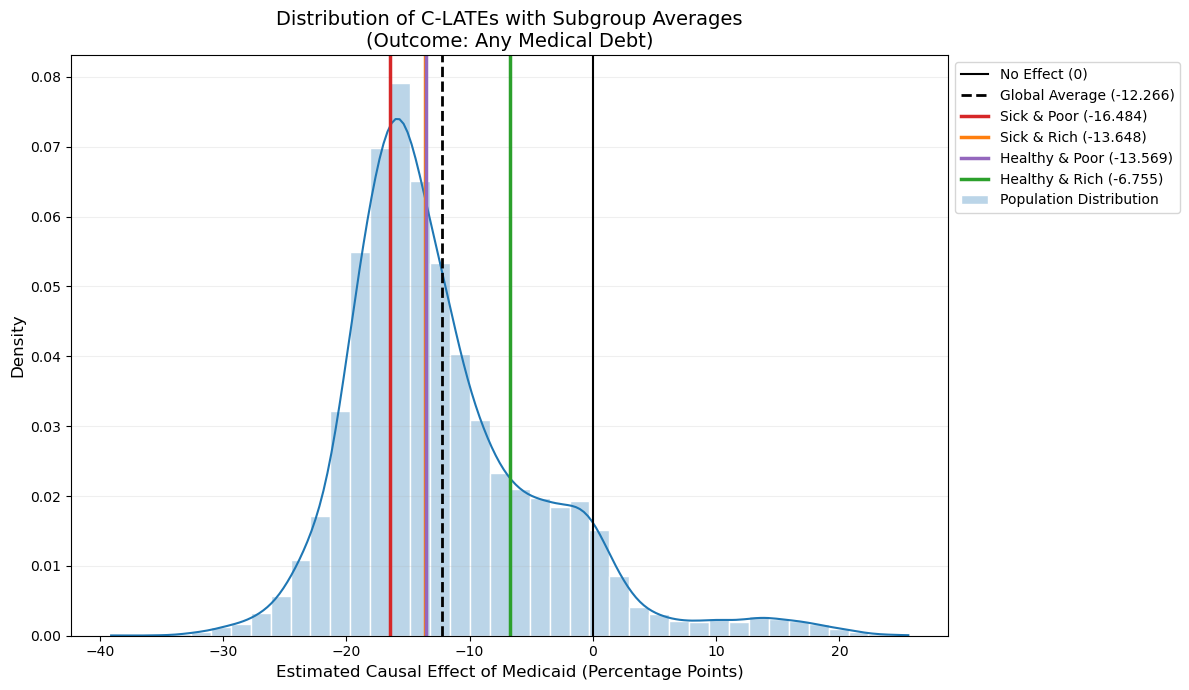

In [33]:
# Setup Data
# Use the results for the primary outcome: "Any Medical Debt"
res = all_results["Y_cost_any_owe_12m"] 

df_viz = res["df_y"].copy()
tau_col = res["tau_col"]
avg_late = res["tau_mean"]

# Calculate Weighted Means for Each Group
def get_weighted_mean(group_name):
    sub = df_viz[df_viz['risk_liq_group'] == group_name]
    return np.average(sub[tau_col], weights=sub['weight_12m'])

# Define Groups and Colors (using a distinct palette)
# High Risk / High Constraint -> Red (Target)
# Low Risk / Low Constraint -> Green (Baseline)
groups_to_plot = {
    "High risk, high constraint": ("#d62728", "Sick & Poor"),       # Red
    "High risk, low constraint":  ("#ff7f0e", "Sick & Rich"),       # Orange
    "Low risk, high constraint":  ("#9467bd", "Healthy & Poor"),    # Purple
    "Low risk, low constraint":   ("#2ca02c", "Healthy & Rich") }    # Green

# Create Plot
plt.figure(figsize=(12, 7))

# Histogram + Density (KDE)
sns.histplot(
    df_viz[tau_col]*100, 
    kde=True, 
    color="#1f77b4", # Standard 'publication blue'
    stat="density", 
    bins=40,
    alpha=0.3,       # Lighter to let lines pop
    edgecolor='white',
    label='Population Distribution')

# Add Zero Line (No Effect)
plt.axvline(0, color='black', linestyle='-', linewidth=1.5, label='No Effect (0)')

# Add the Benchmark Average Line
plt.axvline(avg_late*100, color='black', linestyle='--', linewidth=2, 
            label=f'Global Average ({avg_late*100:.3f})')

# Add Group Average Lines
for group_name, (color, label) in groups_to_plot.items():
    mean_val = get_weighted_mean(group_name)*100
    plt.axvline(mean_val, color=color, linestyle='-', linewidth=2.5, 
                label=f'{label} ({mean_val:.3f})')

# Formatting
plt.title("Distribution of C-LATEs with Subgroup Averages\n(Outcome: Any Medical Debt)", fontsize=14)
plt.xlabel("Estimated Causal Effect of Medicaid (Percentage Points)", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Place Legend outside to prevent clutter
plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.2)

# Save
plt.tight_layout()
plt.savefig("../Output/fig_1_histogram.png", dpi=300, bbox_inches="tight") 
plt.show()

Generating Final Landscape Heatmap (Interpolated & Smoothed)...


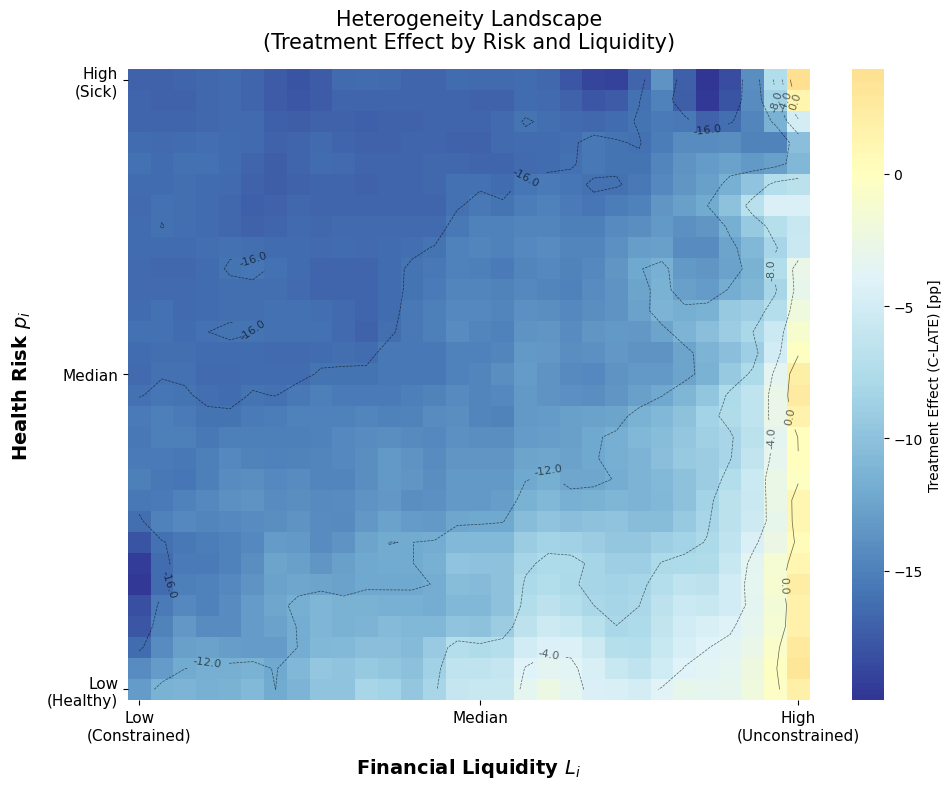

In [34]:
import warnings
warnings.filterwarnings("ignore")

print("Generating Final Landscape Heatmap (Interpolated & Smoothed)...")

# Setup data
res = all_results["Y_cost_any_owe_12m"]
df_viz = res["df_y"].copy()
tau_col = res["tau_col"]
risk_col = "risk_index_0m"
liquidity_col = "liquidity_index_0m"

# Drop missing
df_viz = df_viz.dropna(subset=[tau_col, risk_col, liquidity_col, "weight_12m"]).copy()

# Create quantile bins (30x30)
n_bins = 30
df_viz["risk_bin"] = pd.qcut(df_viz[risk_col], q=n_bins, labels=False, duplicates="drop")
df_viz["liq_bin"] = pd.qcut(df_viz[liquidity_col], q=n_bins, labels=False, duplicates="drop")

# Pivot with Weighted Mean
def weighted_tau(x):
    w = df_viz.loc[x.index, "weight_12m"]
    return np.average(x, weights=w)

heatmap_matrix = df_viz.pivot_table(
    index="risk_bin",
    columns="liq_bin",
    values=tau_col,
    aggfunc=weighted_tau
) * 100.0

# Gap Filling (Interpolation)
# Preserves the gradient instead of flattening it with the global mean
heatmap_matrix = heatmap_matrix.interpolate(method='linear', axis=0).interpolate(method='linear', axis=1)
heatmap_matrix = heatmap_matrix.fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)

# Smoothing
# Makes contours clean and readable
heatmap_smooth = gaussian_filter(heatmap_matrix, sigma=0.8)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Heatmap
sns.heatmap(
    heatmap_smooth,
    cmap="RdYlBu_r", # Blue = Benefit (Negative)
    center=0,        # White = No Effect
    annot=False,
    cbar_kws={"label": "Treatment Effect (C-LATE) [pp]"},
    xticklabels=False,
    yticklabels=False,
    ax=ax
)

# Contour Lines
n_risk_bins, n_liq_bins = heatmap_smooth.shape
x_coords = np.arange(n_liq_bins) + 0.5
y_coords = np.arange(n_risk_bins) + 0.5

CS = ax.contour(
    x_coords, y_coords, heatmap_smooth,
    levels=6, colors="black", linewidths=0.5, alpha=0.6
)
ax.clabel(CS, inline=True, fontsize=8, fmt="%.1f")

# Formatting
ax.set_xlabel("Financial Liquidity $L_i$", fontsize=14, fontweight="bold", labelpad=10)
ax.set_ylabel("Health Risk $p_i$", fontsize=14, fontweight="bold", labelpad=10)
ax.invert_yaxis() # High Risk on Top

# Ticks
xticks = [0, n_liq_bins // 2, n_liq_bins - 1]
yticks = [0, n_risk_bins // 2, n_risk_bins - 1]
ax.set_xticks([x + 0.5 for x in xticks]) # Center ticks
ax.set_yticks([y + 0.5 for y in yticks])

ax.set_xticklabels(["Low\n(Constrained)", "Median", "High\n(Unconstrained)"], fontsize=11)
ax.set_yticklabels(["Low\n(Healthy)", "Median", "High\n(Sick)"], fontsize=11)

plt.title("Heterogeneity Landscape\n(Treatment Effect by Risk and Liquidity)", fontsize=15, pad=15)
plt.tight_layout()
plt.savefig("../Output/fig_2_heatmap.png", dpi=300, bbox_inches="tight") 
plt.show()

Generating Landscape Scatter Plot...


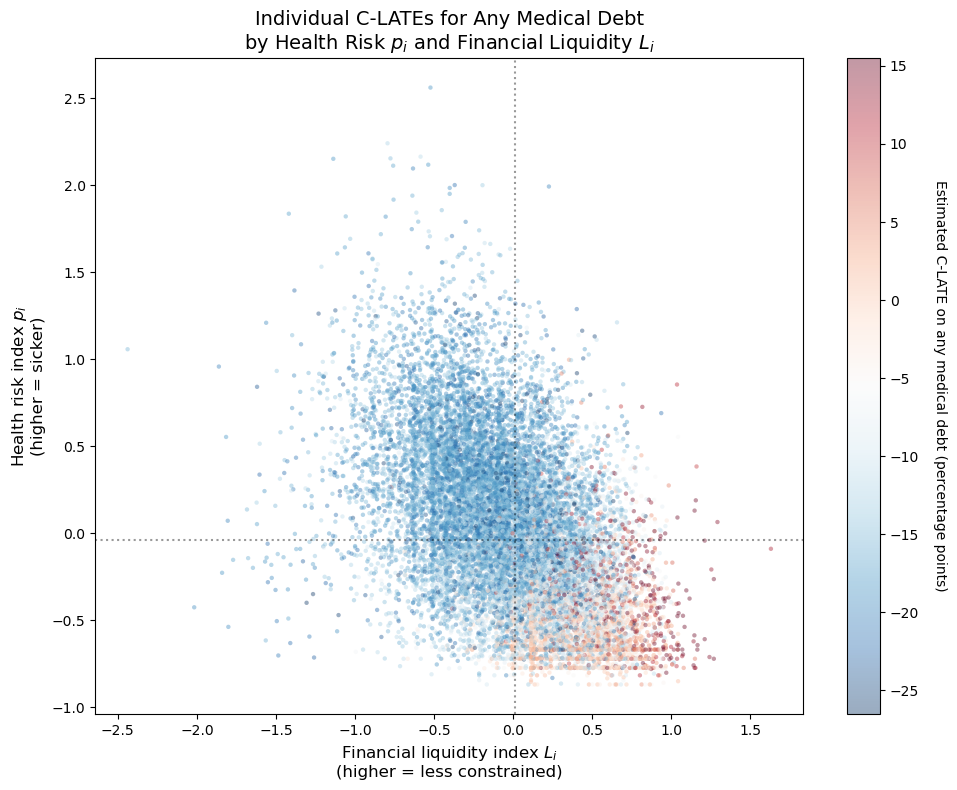

In [35]:
print("Generating Landscape Scatter Plot...")

# Setup data: any medical debt
res = all_results["Y_cost_any_owe_12m"]
df_viz = res["df_y"].copy()
tau_col = res["tau_col"]

# Drop any rows that could break the plot
df_viz = df_viz.dropna(
    subset=[tau_col, "risk_index_0m", "liquidity_index_0m", "weight_12m"]).copy()

# Create scatterplot of individual C-LATEs
plt.figure(figsize=(10, 8))

tau_pp = df_viz[tau_col] * 100  # percentage points

points = plt.scatter(
    df_viz["liquidity_index_0m"],
    df_viz["risk_index_0m"],
    c=tau_pp,
    cmap="RdBu_r",        
    vmin=tau_pp.quantile(0.01),  
    vmax=tau_pp.quantile(0.99),
    alpha=0.4,
    s=10,
    edgecolors="none",)

# 3Colorbar
cbar = plt.colorbar(points)
cbar.set_label("Estimated C-LATE on any medical debt (percentage points)", 
               rotation=270, labelpad=20)

# Formatting and reference lines
plt.title(
    "Individual C-LATEs for Any Medical Debt\n"
    "by Health Risk $p_i$ and Financial Liquidity $L_i$",
    fontsize=14,
)

plt.xlabel("Financial liquidity index $L_i$\n(higher = less constrained)", fontsize=12)
plt.ylabel("Health risk index $p_i$\n(higher = sicker)", fontsize=12)

# Median splits to visually mark the four quadrants
plt.axhline(df_viz["risk_index_0m"].median(), color="black", linestyle=":", alpha=0.4)
plt.axvline(df_viz["liquidity_index_0m"].median(), color="black", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.savefig("../Output/fig_3_scatter.png", dpi=300, bbox_inches="tight")  
plt.show()

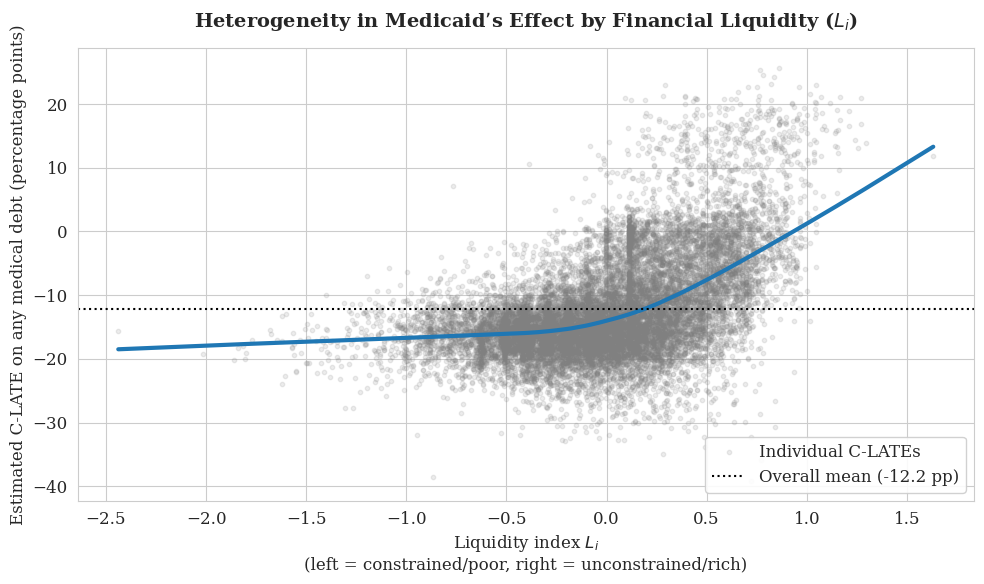

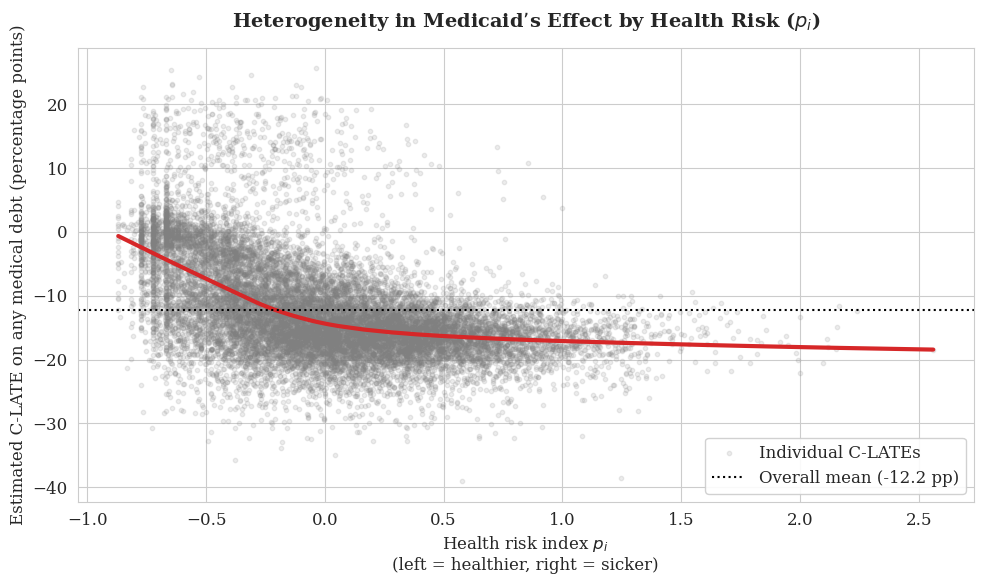

In [36]:
# Use the results for your main outcome: "Any Medical Debt"
res = all_results["Y_cost_any_owe_12m"]
df_viz = res["df_y"].copy()
tau_col = res["tau_col"]

# Convert tau_hat to percentage points once
df_viz["tau_pp"] = df_viz[tau_col] * 100

sns.set_style("whitegrid")
plt.rcParams.update({"font.family": "serif", "font.size": 12})

# Helper function to standardize plot aesthetics
def plot_continuous_gradient(x_col, y_col_pp, data, title, xlabel, filename, color):
    plt.figure(figsize=(10, 6))

    # Scatter of individual C-LATEs (in pp)
    plt.scatter(
        data[x_col],
        data[y_col_pp],
        alpha=0.15,
        color="gray",
        s=10,
        label="Individual C-LATEs",
    )

    # Smooth trend (LOWESS) – descriptive, not inferential
    sns.regplot(
        x=x_col,
        y=y_col_pp,
        data=data,
        scatter=False,
        lowess=True,
        color=color,
        line_kws={"linewidth": 3, "label": "Smoothed average (LOWESS)"},
    )

    # Reference line: overall mean C-LATE
    avg_late_pp = data[y_col_pp].mean()
    plt.axhline(
        avg_late_pp,
        color="black",
        linestyle=":",
        linewidth=1.5,
        label=f"Overall mean ({avg_late_pp:.1f} pp)",
    )

    # Formatting
    plt.title(title, fontsize=14, fontweight="bold", pad=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Estimated C-LATE on any medical debt (percentage points)", fontsize=12)
    plt.legend(loc="lower right", frameon=True, framealpha=0.9)

    plt.tight_layout()
    plt.savefig(f"../Output/{filename}", dpi=300)
    plt.show()


# ========================================================
# GRAPH 1: C-LATE by LIQUIDITY (L_i)
# Expectation: richer / less constrained → smaller (less negative) effect
# ========================================================
plot_continuous_gradient(
    x_col="liquidity_index_0m",
    y_col_pp="tau_pp",
    data=df_viz,
    title="Heterogeneity in Medicaid’s Effect by Financial Liquidity ($L_i$)",
    xlabel="Liquidity index $L_i$\n(left = constrained/poor, right = unconstrained/rich)",
    filename="fig_continuous_liquidity.png",
    color="#1f77b4",
)

# ========================================================
# GRAPH 2: C-LATE by HEALTH RISK (p_i)
# Expectation: higher risk → larger (more negative) effect
# ========================================================
plot_continuous_gradient(
    x_col="risk_index_0m",
    y_col_pp="tau_pp",
    data=df_viz,
    title="Heterogeneity in Medicaid’s Effect by Health Risk ($p_i$)",
    xlabel="Health risk index $p_i$\n(left = healthier, right = sicker)",
    filename="fig_continuous_risk.png",
    color="#d62728",
)


In [37]:
# Use the same group_order you’ve been using
group_order = [
    "Low risk, low constraint",
    "Low risk, high constraint",
    "High risk, low constraint",
    "High risk, high constraint",
]

def plot_group_cis_for_any_debt(
    all_results,
    group_order=group_order,
    weight_col="weight_12m",
    group_col="risk_liq_group",
    cluster_col="household_id",
):
    """
    For Y_cost_any_owe_12m, plot 4 group-specific C-LATEs with
    95% cluster-robust confidence intervals, in percentage points.
    
    Uses: tau_hat ~ C(risk_liq_group), WLS with survey weights,
    clustered at the household level.

    Note: As throughout the paper, tau_hat is treated as observed;
    these CIs do NOT propagate first-stage IV-forest uncertainty.
    """

    # Grab outcome-specific data
    res = all_results["Y_cost_any_owe_12m"]
    df_y = res["df_y"].copy()
    tau_col = res["tau_col"]

    # Clean sample: match run_group_wls_on_tau logic
    df_tau = df_y.loc[df_y[weight_col] > 0].dropna(
        subset=[tau_col, group_col, weight_col, cluster_col]
    ).copy()

    # Ensure categorical with fixed ordering
    df_tau[group_col] = pd.Categorical(
        df_tau[group_col],
        categories=group_order,
        ordered=True,
    )

    # Fit WLS with cluster-robust SEs
    formula = f"{tau_col} ~ C({group_col})"
    w = df_tau[weight_col]

    mod = smf.wls(formula=formula, data=df_tau, weights=w)
    res_wls = mod.fit(
        cov_type="cluster",
        cov_kwds={"groups": df_tau[cluster_col]},
    )

    # Construct group-level effects as linear combinations
    #    of intercept + dummies, using cov(params) for SEs
    params = res_wls.params
    cov = res_wls.cov_params()

    # Make sure the parameter order is as expected
    print("\nWLS coefficients for check:")
    print(params)

    rows = []
    # Parameter order should be:
    # [Intercept,
    #  C(group)[T.Low risk, high constraint],
    #  C(group)[T.High risk, low constraint],
    #  C(group)[T.High risk, high constraint]]

    for g in group_order:
        if g == "Low risk, low constraint":
            # baseline: intercept only
            L = np.array([1.0, 0.0, 0.0, 0.0])
        elif g == "Low risk, high constraint":
            L = np.array([1.0, 1.0, 0.0, 0.0])
        elif g == "High risk, low constraint":
            L = np.array([1.0, 0.0, 1.0, 0.0])
        elif g == "High risk, high constraint":
            L = np.array([1.0, 0.0, 0.0, 1.0])
        else:
            raise ValueError(f"Unexpected group label: {g}")

        theta = float(L @ params.values)
        var_theta = float(L @ cov.values @ L)
        se = np.sqrt(var_theta)

        # Scale to percentage points (binary outcome)
        effect_pp = theta * 100.0
        se_pp = se * 100.0
        ci_low_pp = effect_pp - 1.96 * se_pp
        ci_high_pp = effect_pp + 1.96 * se_pp

        rows.append(
            {
                "group": g,
                "effect_pp": effect_pp,
                "se_pp": se_pp,
                "ci_low_pp": ci_low_pp,
                "ci_high_pp": ci_high_pp,
            }
        )

    group_ci_df = pd.DataFrame(rows)

    print("\nGroup-specific C-LATEs with 95% CIs (pp):")
    display(group_ci_df)

    # Plot: dot + 95% CI whiskers
    fig, ax = plt.subplots(figsize=(8, 5))

    x = np.arange(len(group_ci_df))
    y = group_ci_df["effect_pp"].values
    yerr = 1.96 * group_ci_df["se_pp"].values

    ax.errorbar(
        x,
        y,
        yerr=yerr,
        fmt="o",
        capsize=4,
        linewidth=1.5,
        color="#1f77b4",
        ecolor="#1f77b4",
    )

    # Reference line at zero effect
    ax.axhline(0.0, color="black", linestyle="--", linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(group_ci_df["group"], rotation=20, ha="right")
    ax.set_ylabel("C-LATE on any medical debt (percentage points)", fontsize=12)
    ax.set_title(
        "Figure X: Medicaid’s Effect on Any Medical Debt\n"
        "with 95% Cluster-Robust CIs by Risk–Liquidity Group",
        fontsize=14,
        pad=15,
    )

    plt.tight_layout()
    plt.savefig("../Output/fig_sd_line.png", dpi=300, bbox_inches="tight")  
    plt.show()

    return group_ci_df


WLS coefficients for check:
Intercept                                         -0.067554
C(risk_liq_group)[T.Low risk, high constraint]    -0.068134
C(risk_liq_group)[T.High risk, low constraint]    -0.068930
C(risk_liq_group)[T.High risk, high constraint]   -0.097284
dtype: float64

Group-specific C-LATEs with 95% CIs (pp):


,group,effect_pp,se_pp,ci_low_pp,ci_high_pp
0,"Low risk, low constraint",-6.755400,0.138325,-7.026518,-6.484282
1,"Low risk, high constraint",-13.568755,0.126595,-13.816881,-13.320628
2,"High risk, low constraint",-13.648389,0.153713,-13.949667,-13.347112
3,"High risk, high constraint",-16.483794,0.057678,-16.596842,-16.370746


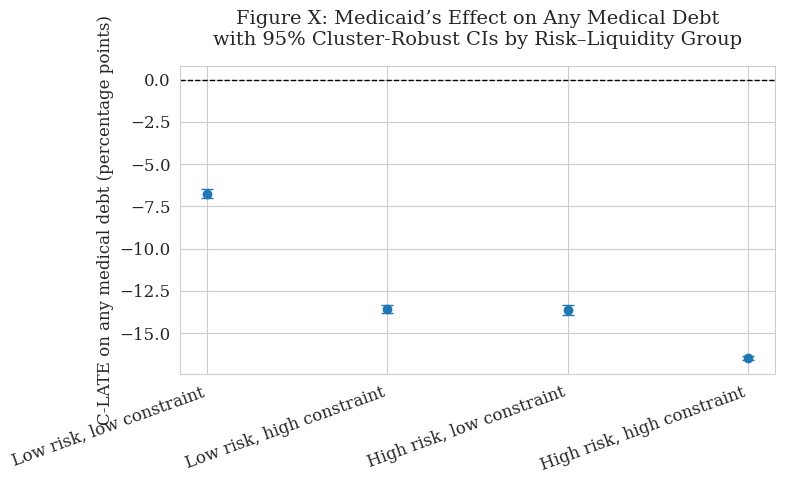

In [38]:
group_ci_any_debt = plot_group_cis_for_any_debt(all_results)

# Policy

## Ignoring Compliance

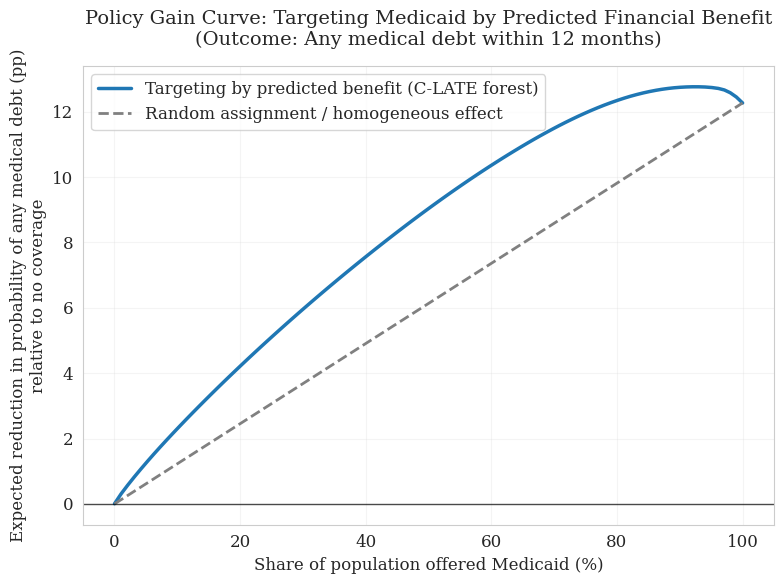

In [39]:
def plot_policy_gain_curve_any_debt(
    all_results,
    y_name="Y_cost_any_owe_12m",
    weight_col="weight_12m",
    n_points=100,
):
    """
    Policy gain curve for outcome y_name (default: any medical debt).

    Uses ONLY the C-LATEs from the IV-forest:
        - res["df_y"][tau_col] as tau_hat_i
    and survey weights `weight_12m`.

    Interprets tau_hat < 0 as "reduction in probability of any medical debt".
    Plots expected reduction (in percentage points) as you expand coverage
    from 0% to 100% of the population, targeting those with largest predicted benefit.

    Benchmark line: linear curve corresponding to treating people randomly
    (or equivalently, homogeneous effect = overall mean C-LATE).
    """

    # Grab outcome-specific results from the IV-forest pipeline
    res = all_results[y_name]
    df = res["df_y"].copy()
    tau_col = res["tau_col"]        # IV-forest C-LATE column
    # tau is effect on debt probability (negative = good)
    
    # Clean sample
    df = df.dropna(subset=[tau_col, weight_col]).copy()
    w = df[weight_col].to_numpy(dtype=float)

    # Define "benefit" as REDUCTION in debt probability (pp, positive = good)
    # tau_hat is in probability units, so multiply by -100 to get +pp benefit
    tau_hat = df[tau_col].to_numpy(dtype=float)
    benefit_pp = -tau_hat * 100.0      # positive = larger reduction in probability

    # Sort individuals by predicted benefit (descending)
    order = np.argsort(-benefit_pp)    # highest benefit first
    benefit_pp_sorted = benefit_pp[order]
    w_sorted = w[order]

    # Cumulative share of population (x-axis) and cumulative average benefit (y-axis)
    w_cum = np.cumsum(w_sorted)
    w_total = w_sorted.sum()
    share = w_cum / w_total           

    # Cumulative total benefit per capita in pp:
    # at share s: sum_{i in top-s} benefit_i * w_i / sum_all w
    cum_benefit_per_capita_pp = np.cumsum(benefit_pp_sorted * w_sorted) / w_total

    # Benchmark: "random / homogeneous effect" line
    # If everyone gets covered, avg benefit = mean(benefit_pp, weighted)
    mean_benefit_pp = np.sum(benefit_pp * w) / w_total
    # Under randomness, the expected gain grows linearly with coverage share
    benchmark_gain_pp = share * mean_benefit_pp

    # downsample for a slightly smoother line (purely cosmetic)
    if len(share) > n_points:
        idx = np.linspace(0, len(share) - 1, n_points).astype(int)
        share_plot = share[idx]
        gain_plot = cum_benefit_per_capita_pp[idx]
        bench_plot = benchmark_gain_pp[idx]
    else:
        share_plot = share
        gain_plot = cum_benefit_per_capita_pp
        bench_plot = benchmark_gain_pp

    # Plot
    plt.figure(figsize=(8, 6))

    plt.plot(
        share_plot * 100,          # % of population
        gain_plot,
        label="Targeting by predicted benefit (C-LATE forest)",
        linewidth=2.5,
    )

    plt.plot(
        share_plot * 100,
        bench_plot,
        linestyle="--",
        color="gray",
        label="Random assignment / homogeneous effect",
        linewidth=2,
    )

    plt.axhline(0, color="black", linewidth=1, alpha=0.7)

    # Labels & titles
    plt.xlabel("Share of population offered Medicaid (%)", fontsize=12)
    plt.ylabel(
        "Expected reduction in probability of any medical debt (pp)\n"
        "relative to no coverage",
        fontsize=12,
    )

    plt.title(
        "Policy Gain Curve: Targeting Medicaid by Predicted Financial Benefit\n"
        "(Outcome: Any medical debt within 12 months)",
        fontsize=14,
        pad=15,
    )

    plt.legend(frameon=True)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig("../Output/fig_policy.png", dpi=300, bbox_inches="tight")  
    plt.show()

    gain_df = pd.DataFrame(
        {
            "share_pop": share,
            "cum_benefit_pp": cum_benefit_per_capita_pp,
            "benchmark_pp": benchmark_gain_pp,
        }
    )

    return gain_df

gain_df_any_debt = plot_policy_gain_curve_any_debt(all_results)

## Considering Compliance

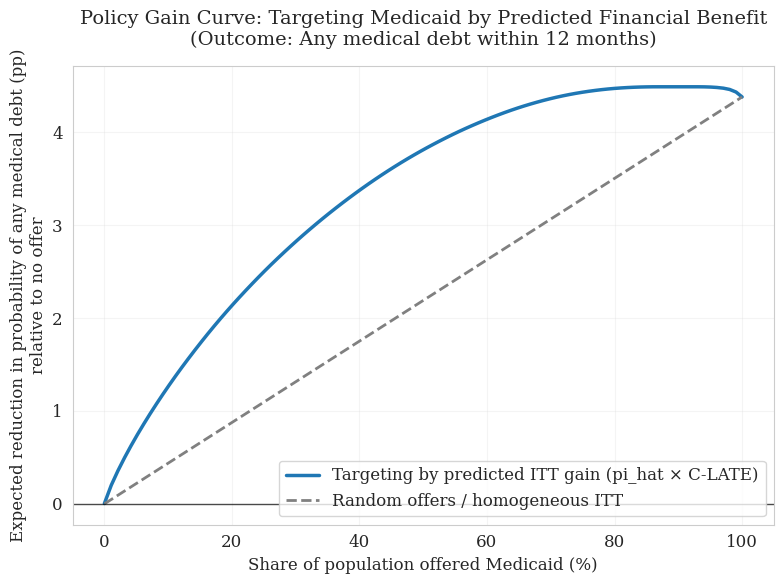

In [40]:
def plot_policy_gain_curve_any_debt(
    all_results,
    y_name="Y_cost_any_owe_12m",
    weight_col="weight_12m",
    n_points=100,
    z_col="Z_lottery",
    w_col="W_medicaid",
    risk_col="risk_index_0m",
    liquidity_col="liquidity_index_0m",
    n_bins=30,
    clip_pi_hat_at_zero=True,   # set True if you want to impose monotonicity (no defiers)
):
    """
    Policy gain curve for targeting *offers* (Z) under noncompliance.

    Uses:
      - tau_hat_i from your IV-forest (res["tau_col"])  [a C-LATE/LATE among compliers]
      - pi_hat(cell) = E[W|Z=1,cell] - E[W|Z=0,cell]    [conditional first stage]
    Targeting score:
      - ITT_hat_i = pi_hat(cell_i) * tau_hat_i
      - benefit_pp = -(ITT_hat_i) * 100  (positive = reduction in debt probability per offer)

    This is an in-sample policy-gain curve (descriptive).
    """

    # Pull already-estimated forest outputs (no re-estimation happens here)
    res = all_results[y_name]
    df = res["df_y"].copy()
    tau_col = res["tau_col"]

    # Clean sample (np.average requires positive total weights)
    df = df.dropna(subset=[tau_col, weight_col, z_col, w_col, risk_col, liquidity_col]).copy()
    df = df.loc[df[weight_col] > 0].copy()

    # Ensure Z is binary 0/1
    df[z_col] = df[z_col].astype(int)

    # Estimate conditional first stage pi_hat via (risk_bin, liq_bin)
    df["risk_bin"] = pd.qcut(df[risk_col], q=n_bins, labels=False, duplicates="drop")
    df["liq_bin"]  = pd.qcut(df[liquidity_col], q=n_bins, labels=False, duplicates="drop")

    cell_means = (
        df.groupby(["risk_bin", "liq_bin", z_col], sort=False)
          .apply(lambda g: np.average(g[w_col], weights=g[weight_col]))
          .rename("wmean_W")
          .reset_index())

    cell_piv = cell_means.pivot_table(
        index=["risk_bin", "liq_bin"],
        columns=z_col,
        values="wmean_W",
        aggfunc="first",)

    # Guarantee both columns exist before differencing
    if 0 not in cell_piv.columns:
        cell_piv[0] = np.nan
    if 1 not in cell_piv.columns:
        cell_piv[1] = np.nan

    cell_piv["pi_hat"] = cell_piv[1] - cell_piv[0]
    cell_piv = cell_piv[["pi_hat"]].reset_index()

    # Merge pi_hat back (many-to-one)
    df = df.merge(cell_piv, on=["risk_bin", "liq_bin"], how="left")

    # Overall weighted first stage fallback
    fs1 = np.average(df.loc[df[z_col] == 1, w_col], weights=df.loc[df[z_col] == 1, weight_col])
    fs0 = np.average(df.loc[df[z_col] == 0, w_col], weights=df.loc[df[z_col] == 0, weight_col])
    pi_overall = fs1 - fs0
    df["pi_hat"] = df["pi_hat"].fillna(pi_overall)

    if clip_pi_hat_at_zero:
        df["pi_hat"] = df["pi_hat"].clip(lower=0.0)

    # Weights AFTER merge (alignment guaranteed)
    w = df[weight_col].to_numpy(dtype=float)
    w_total = w.sum()
    if not np.isfinite(w_total) or w_total <= 0:
        raise ValueError("Total weight is non-positive or non-finite after cleaning.")

    # Predicted ITT gain from offers
    tau_hat = df[tau_col].to_numpy(dtype=float)                     
    itt_hat = df["pi_hat"].to_numpy(dtype=float) * tau_hat          
    benefit_pp = -itt_hat * 100.0                                   

    # Sort by predicted benefit
    order = np.argsort(-benefit_pp)
    benefit_pp_sorted = benefit_pp[order]
    w_sorted = w[order]

    # Policy gain curve (per-capita, weighted)
    w_cum = np.cumsum(w_sorted)
    share = w_cum / w_total
    cum_benefit_per_capita_pp = np.cumsum(benefit_pp_sorted * w_sorted) / w_total

    # Benchmark: random offers / homogeneous ITT
    mean_benefit_pp = np.sum(benefit_pp * w) / w_total
    benchmark_gain_pp = share * mean_benefit_pp

    # Downsample for plotting (force last point included)
    if len(share) > n_points:
        idx = np.unique(np.r_[np.linspace(0, len(share) - 1, n_points).astype(int), len(share) - 1])
        share_plot = share[idx]
        gain_plot = cum_benefit_per_capita_pp[idx]
        bench_plot = benchmark_gain_pp[idx]
    else:
        share_plot = share
        gain_plot = cum_benefit_per_capita_pp
        bench_plot = benchmark_gain_pp

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(share_plot * 100, gain_plot, label="Targeting by predicted ITT gain (pi_hat × C-LATE)", linewidth=2.5)
    plt.plot(share_plot * 100, bench_plot, linestyle="--", color="gray",
             label="Random offers / homogeneous ITT", linewidth=2)
    plt.axhline(0, color="black", linewidth=1, alpha=0.7)
    plt.xlabel("Share of population offered Medicaid (%)", fontsize=12)
    plt.ylabel("Expected reduction in probability of any medical debt (pp)\nrelative to no offer", fontsize=12)
    plt.title("Policy Gain Curve: Targeting Medicaid by Predicted Financial Benefit\n"
              "(Outcome: Any medical debt within 12 months)", fontsize=14, pad=15)
    plt.legend(frameon=True)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig("../Output/fig_policy_with_compliance.png", dpi=300, bbox_inches="tight")  
    plt.show()

    return pd.DataFrame({
        "share_pop": share,
        "cum_benefit_pp": cum_benefit_per_capita_pp,
        "benchmark_pp": benchmark_gain_pp,
    })
gain_df_any_debt = plot_policy_gain_curve_any_debt(all_results)
